In [1]:
# Import your custom modules
import sys
sys.path.append('../scripts')

from data_validation import quick_test, full_environment_check
from factoring_analyzer import FactoringAnalyzer, analyze_invoices

print("✅ Modules imported successfully!")

✅ Modules imported successfully!


In [2]:
# Run quick validation test
results = quick_test('../data/TecnoCargoInvoiceDataset01.csv', encoding='latin1')

🔍 TESTING DATA LOADING & VALIDATION
1. Loading raw data...
   ✅ Loaded 3766 records with 10 columns (encoding: latin1)

2. Column information:
    1. Type (object)
    2. Number (object)
    3. Transaction Date (object)
    4. Applied to (object)
    5. Amount (USD) (object)
    6. Due Date (object)
    7. Status (object)
    8. Last Payment Date (object)
    9. Amt. Paid (USD) (object)
   10. Amt. Due (USD) (object)

3. Type distribution:
   Invoice: 3697 records
   Credit Memo: 69 records

4. Sample monetary values (BEFORE cleaning):
   Amount (USD): ['3,509.00', '2,555.00', '1,272.05']
   Data type: object
   Amt. Paid (USD): ['0', '0', '0']
   Data type: object
   Amt. Due (USD): ['3,509.00', '2,555.00', '1,272.05']
   Data type: object

5. Testing monetary column conversion...
   Converting Amount (USD)...
     Before: ['3,509.00', '2,555.00', '1,272.05']
     After:  ['$3,509.00', '$2,555.00', '$1,272.05']
   Converting Amt. Paid (USD)...
     Before: ['0', '0', '0']
     After: 

In [3]:
# 🧪 MM/DD/YYYY FORMAT VERIFICATION TEST
# Run this to verify your manually corrected dataset

import pandas as pd
from datetime import datetime
import numpy as np

def verify_mmddyyyy_format():
    """Comprehensive test to verify MM/DD/YYYY format and date type conversion"""
    
    print("🧪 MM/DD/YYYY FORMAT VERIFICATION TEST")
    print("="*60)
    
    # Load data
    df = pd.read_csv('../data/TecnoCargoInvoiceDataset01.csv', encoding='latin1')
    invoices = df[df['Type'] == 'Invoice'].copy()
    
    print(f"📊 Dataset loaded:")
    print(f"   Total records: {len(df)}")
    print(f"   Invoice records: {len(invoices)}")
    
    # STEP 1: Show raw date samples
    print(f"\n1️⃣ RAW DATE SAMPLES (Before Conversion)")
    print("-" * 50)
    
    date_columns = ['Transaction Date', 'Due Date', 'Last Payment Date']
    
    for col in date_columns:
        if col in invoices.columns:
            # Get non-null samples
            samples = invoices[col].dropna().head(10).tolist()
            null_count = invoices[col].isnull().sum()
            
            print(f"\n   {col}:")
            print(f"     Data type: {invoices[col].dtype}")
            print(f"     Null values: {null_count}")
            print(f"     Sample values: {samples}")
    
    # STEP 2: Test MM/DD/YYYY conversion
    print(f"\n2️⃣ TESTING MM/DD/YYYY CONVERSION")
    print("-" * 50)
    
    conversion_results = {}
    
    for col in date_columns:
        if col in invoices.columns:
            print(f"\n   Converting {col}...")
            
            # Track original nulls
            original_nulls = invoices[col].isnull().sum()
            original_count = len(invoices[col])
            
            # Convert using MM/DD/YYYY format
            invoices[col] = pd.to_datetime(invoices[col], format='%m/%d/%Y', errors='coerce')
            
            # Track conversion results
            new_nulls = invoices[col].isnull().sum()
            conversion_failures = new_nulls - original_nulls
            success_rate = ((original_count - new_nulls) / original_count) * 100
            
            conversion_results[col] = {
                'original_nulls': original_nulls,
                'new_nulls': new_nulls,
                'conversion_failures': conversion_failures,
                'success_rate': success_rate
            }
            
            print(f"     Original nulls: {original_nulls}")
            print(f"     New nulls: {new_nulls}")
            print(f"     Conversion failures: {conversion_failures}")
            print(f"     Success rate: {success_rate:.1f}%")
            print(f"     New data type: {invoices[col].dtype}")
            
            # Show converted samples
            converted_samples = invoices[col].dropna().head(5).tolist()
            print(f"     Converted samples: {converted_samples}")
    
    # STEP 3: Verify date types
    print(f"\n3️⃣ DATE TYPE VERIFICATION")
    print("-" * 50)
    
    for col in date_columns:
        if col in invoices.columns:
            is_datetime = pd.api.types.is_datetime64_any_dtype(invoices[col])
            print(f"   {col}: {'✅ DateTime' if is_datetime else '❌ Not DateTime'}")
            
            if is_datetime:
                # Show that we can extract date components
                sample_date = invoices[col].dropna().iloc[0]
                print(f"     Sample: {sample_date}")
                print(f"     Year: {sample_date.year}")
                print(f"     Month: {sample_date.month}")
                print(f"     Day: {sample_date.day}")
    
    # STEP 4: Format validation tests
    print(f"\n4️⃣ MM/DD/YYYY FORMAT VALIDATION")
    print("-" * 50)
    
    # Test known patterns that should work with MM/DD/YYYY
    test_dates = [
        "01/01/2024",  # January 1, 2024
        "12/31/2024",  # December 31, 2024
        "06/23/2025",  # June 23, 2025
        "02/29/2024"   # Leap year test
    ]
    
    print("   Testing known MM/DD/YYYY patterns:")
    for test_date in test_dates:
        try:
            converted = pd.to_datetime(test_date, format='%m/%d/%Y')
            print(f"     '{test_date}' → {converted} ✅")
        except Exception as e:
            print(f"     '{test_date}' → Failed: {e} ❌")
    
    # STEP 5: Logical validation
    print(f"\n5️⃣ LOGICAL DATE VALIDATION")
    print("-" * 50)
    
    if len(invoices) > 0:
        # Check date ranges
        for col in date_columns:
            if col in invoices.columns and invoices[col].notna().any():
                min_date = invoices[col].min()
                max_date = invoices[col].max()
                date_range_days = (max_date - min_date).days
                
                print(f"   {col}:")
                print(f"     Date range: {min_date} to {max_date}")
                print(f"     Span: {date_range_days} days")
                
                # Check if dates are reasonable (not in future beyond 2025, not before 2020)
                current_year = datetime.now().year
                reasonable_min = datetime(2020, 1, 1)
                reasonable_max = datetime(2026, 12, 31)
                
                reasonable = reasonable_min <= min_date <= reasonable_max and reasonable_min <= max_date <= reasonable_max
                print(f"     Reasonable range: {'✅ Yes' if reasonable else '❌ No'}")
    
    # STEP 6: Split and aging test
    print(f"\n6️⃣ AGING CALCULATION TEST")
    print("-" * 50)
    
    paid_invoices = invoices[invoices['Last Payment Date'].notna()].copy()
    outstanding_invoices = invoices[invoices['Last Payment Date'].isna()].copy()
    
    print(f"   Paid invoices: {len(paid_invoices)}")
    print(f"   Outstanding invoices: {len(outstanding_invoices)}")
    
    # Test aging calculations
    dataset_date = datetime(2025, 6, 23)
    
    if len(paid_invoices) > 0:
        paid_invoices['Aging_Delay'] = (paid_invoices['Last Payment Date'] - paid_invoices['Due Date']).dt.days
        avg_payment_delay = paid_invoices['Aging_Delay'].mean()
        print(f"   💰 Paid avg delay: {avg_payment_delay:.1f} days")
        
        # Show some examples
        print(f"   Sample paid invoice aging:")
        for i, (_, row) in enumerate(paid_invoices.head(3).iterrows()):
            if pd.notna(row['Due Date']) and pd.notna(row['Last Payment Date']):
                print(f"     Invoice {row['Number']}: Due {row['Due Date'].strftime('%Y-%m-%d')}, " +
                      f"Paid {row['Last Payment Date'].strftime('%Y-%m-%d')}, " +
                      f"Delay: {row['Aging_Delay']} days")
    
    if len(outstanding_invoices) > 0:
        outstanding_invoices['Aging_Delay'] = (dataset_date - outstanding_invoices['Due Date']).dt.days
        avg_overdue = outstanding_invoices['Aging_Delay'].mean()
        print(f"   ⏳ Outstanding avg overdue: {avg_overdue:.1f} days")
        
        # Show some examples
        print(f"   Sample outstanding invoice aging:")
        for i, (_, row) in enumerate(outstanding_invoices.head(3).iterrows()):
            if pd.notna(row['Due Date']):
                print(f"     Invoice {row['Number']}: Due {row['Due Date'].strftime('%Y-%m-%d')}, " +
                      f"Days overdue: {row['Aging_Delay']} days")
    
    # STEP 7: Overall assessment
    print(f"\n7️⃣ OVERALL ASSESSMENT")
    print("-" * 50)
    
    # Calculate overall success metrics
    total_conversions = sum(len(invoices) - result['original_nulls'] for result in conversion_results.values())
    total_failures = sum(result['conversion_failures'] for result in conversion_results.values())
    overall_success_rate = ((total_conversions - total_failures) / total_conversions * 100) if total_conversions > 0 else 0
    
    print(f"   Overall conversion success rate: {overall_success_rate:.1f}%")
    
    # Assessment criteria
    assessments = []
    
    if overall_success_rate >= 95:
        assessments.append("✅ Excellent conversion rate")
    elif overall_success_rate >= 85:
        assessments.append("⚠️ Good conversion rate, minor issues")
    else:
        assessments.append("❌ Poor conversion rate, major issues")
    
    if avg_payment_delay < 60 and avg_overdue < 300:
        assessments.append("✅ Reasonable aging calculations")
    else:
        assessments.append("⚠️ Aging calculations seem high")
    
    all_datetime = all(pd.api.types.is_datetime64_any_dtype(invoices[col]) for col in date_columns if col in invoices.columns)
    if all_datetime:
        assessments.append("✅ All date columns are proper DateTime type")
    else:
        assessments.append("❌ Some date columns are not DateTime type")
    
    print(f"\n   📋 ASSESSMENT SUMMARY:")
    for assessment in assessments:
        print(f"     {assessment}")
    
    if overall_success_rate >= 95 and all_datetime and avg_payment_delay < 60:
        print(f"\n   🎉 SUCCESS! Your dataset is properly formatted with MM/DD/YYYY dates!")
        print(f"   🚀 Ready to proceed with full factoring analysis!")
    else:
        print(f"\n   🔧 Some issues detected. Review the results above.")
    
    return {
        'conversion_results': conversion_results,
        'overall_success_rate': overall_success_rate,
        'all_datetime': all_datetime,
        'paid_invoices': len(paid_invoices),
        'outstanding_invoices': len(outstanding_invoices),
        'avg_payment_delay': avg_payment_delay if len(paid_invoices) > 0 else None,
        'avg_overdue': avg_overdue if len(outstanding_invoices) > 0 else None
    }

# 🚀 RUN THE VERIFICATION TEST
print("🚀 Starting MM/DD/YYYY format verification...")
results = verify_mmddyyyy_format()

print(f"\n📊 FINAL RESULTS SUMMARY:")
print(f"   Conversion success: {results['overall_success_rate']:.1f}%")
print(f"   All DateTime types: {results['all_datetime']}")
print(f"   Paid invoices: {results['paid_invoices']}")
print(f"   Outstanding invoices: {results['outstanding_invoices']}")
if results['avg_payment_delay']:
    print(f"   Avg payment delay: {results['avg_payment_delay']:.1f} days")
if results['avg_overdue']:
    print(f"   Avg days overdue: {results['avg_overdue']:.1f} days")

🚀 Starting MM/DD/YYYY format verification...
🧪 MM/DD/YYYY FORMAT VERIFICATION TEST
📊 Dataset loaded:
   Total records: 3766
   Invoice records: 3697

1️⃣ RAW DATE SAMPLES (Before Conversion)
--------------------------------------------------

   Transaction Date:
     Data type: object
     Null values: 0
     Sample values: ['6/23/2025', '6/23/2025', '6/23/2025', '6/23/2025', '6/23/2025', '6/20/2025', '6/20/2025', '6/20/2025', '6/20/2025', '6/20/2025']

   Due Date:
     Data type: object
     Null values: 0
     Sample values: ['6/24/2025', '7/23/2025', '9/21/2025', '9/21/2025', '6/24/2025', '6/20/2025', '7/20/2025', '6/21/2025', '6/21/2025', '6/20/2025']

   Last Payment Date:
     Data type: object
     Null values: 245
     Sample values: ['6/23/2025', '6/20/2025', '6/19/2025', '6/19/2025', '6/18/2025', '6/16/2025', '6/12/2025', '6/17/2025', '6/10/2025', '6/10/2025']

2️⃣ TESTING MM/DD/YYYY CONVERSION
--------------------------------------------------

   Converting Transaction Da

In [4]:
# 🏢 COMPLETE CORRECTED FACTORING ANALYZER CLASS
# Copy and run this entire cell to define the complete class

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class CorrectedFactoringAnalyzer:
    def __init__(self, csv_path, encoding='latin1'):
        """Initialize with invoice data"""
        try:
            self.df = pd.read_csv(csv_path, encoding=encoding)
            print(f"✅ Data loaded successfully with {encoding} encoding")
        except Exception as e:
            print(f"❌ Error loading data: {e}")
            return
        
        self.prepare_data()
    
    def prepare_data(self):
        """Clean and prepare data for analysis with MM/DD/YYYY format"""
        print("🔧 Starting data preparation...")
        
        # 1. Clean monetary columns
        monetary_columns = ['Amount (USD)', 'Amt. Paid (USD)', 'Amt. Due (USD)']
        for col in monetary_columns:
            if col in self.df.columns:
                print(f"   Converting {col} to numeric...")
                self.df[col] = pd.to_numeric(
                    self.df[col].astype(str)
                    .str.replace('$', '', regex=False)
                    .str.replace(',', '', regex=False)
                    .str.replace('(', '-', regex=False)
                    .str.replace(')', '', regex=False),
                    errors='coerce'
                ).fillna(0)
        
        print("   ✅ Monetary columns converted")
        
        # 2. Split by type
        self.df_invoice = self.df[self.df['Type'] == 'Invoice'].copy()
        self.df_credit_memo = self.df[self.df['Type'] == 'Credit Memo'].copy()
        self.df_full = self.df.copy()
        
        print(f"   📄 Invoice records: {len(self.df_invoice)}")
        print(f"   📝 Credit Memo records: {len(self.df_credit_memo)}")
        
        # 3. Convert dates with MM/DD/YYYY format
        print("📅 Converting date columns (MM/DD/YYYY format)...")
        date_columns = ['Transaction Date', 'Due Date', 'Last Payment Date']
        
        for col in date_columns:
            if col in self.df_invoice.columns:
                self.df_invoice[col] = pd.to_datetime(
                    self.df_invoice[col], 
                    format='%m/%d/%Y', 
                    errors='coerce'
                )
        
        print("   ✅ Date columns converted")
        
        # 4. Split paid vs outstanding
        self.df_paid_invoices = self.df_invoice[self.df_invoice['Last Payment Date'].notna()].copy()
        self.df_outstanding_invoices = self.df_invoice[self.df_invoice['Last Payment Date'].isna()].copy()
        
        print(f"   💰 Paid invoices: {len(self.df_paid_invoices)}")
        print(f"   ⏳ Outstanding invoices: {len(self.df_outstanding_invoices)}")
        
        # 5. Calculate aging delays
        if len(self.df_paid_invoices) > 0:
            self.df_paid_invoices['Aging_Delay'] = (
                self.df_paid_invoices['Last Payment Date'] - 
                self.df_paid_invoices['Due Date']
            ).dt.days
            
            self.df_paid_invoices['Aging_Bucket'] = pd.cut(
                self.df_paid_invoices['Aging_Delay'],
                bins=[-float('inf'), 0, 30, 60, 90, float('inf')],
                labels=['On-time', '1-30 Days', '31-60 Days', '61-90 Days', '90+ Days']
            )
        
        if len(self.df_outstanding_invoices) > 0:
            dataset_date = datetime(2025, 6, 23)
            self.df_outstanding_invoices['Aging_Delay'] = (
                dataset_date - self.df_outstanding_invoices['Due Date']
            ).dt.days
            
            self.df_outstanding_invoices['Aging_Bucket'] = pd.cut(
                self.df_outstanding_invoices['Aging_Delay'],
                bins=[-float('inf'), 0, 30, 60, 90, float('inf')],
                labels=['Current', '1-30 Days', '31-60 Days', '61-90 Days', '90+ Days']
            )
        
        print("✅ Data preparation completed successfully!")

    def paid_invoices_aging_analysis(self):
        """Analyze aging for PAID invoices"""
        print("\n" + "="*60)
        print("💰 PAID INVOICES AGING ANALYSIS")
        print("(How late were payments when received)")
        print("="*60)
        
        if len(self.df_paid_invoices) == 0:
            print("No paid invoices found.")
            return None
        
        # Aging summary
        paid_aging_summary = self.df_paid_invoices.groupby('Aging_Bucket').agg({
            'Number': 'count',
            'Amount (USD)': 'sum',
            'Aging_Delay': ['mean', 'max'],
        }).round(2)
        
        paid_aging_summary.columns = ['Invoice_Count', 'Total_Amount', 'Avg_Days_Late', 'Max_Days_Late']
        paid_aging_summary['Percentage'] = (
            paid_aging_summary['Invoice_Count'] / len(self.df_paid_invoices) * 100
        ).round(2)
        
        print("\nPaid Invoices Aging Summary:")
        print(paid_aging_summary)
        
        # Payment behavior insights
        early_payments = len(self.df_paid_invoices[self.df_paid_invoices['Aging_Delay'] <= 0])
        late_payments = len(self.df_paid_invoices[self.df_paid_invoices['Aging_Delay'] > 0])
        avg_delay = self.df_paid_invoices['Aging_Delay'].mean()
        
        print(f"\n💡 PAYMENT BEHAVIOR:")
        print(f"   Early/On-time: {early_payments} ({early_payments/len(self.df_paid_invoices)*100:.1f}%)")
        print(f"   Late payments: {late_payments} ({late_payments/len(self.df_paid_invoices)*100:.1f}%)")
        print(f"   Average delay: {avg_delay:.1f} days")
        
        # Visualization
        plt.figure(figsize=(15, 6))
        
        plt.subplot(1, 3, 1)
        paid_aging_summary['Invoice_Count'].plot(kind='bar', color='lightblue')
        plt.title('Paid Invoices by Aging')
        plt.ylabel('Number of Invoices')
        plt.xticks(rotation=45)
        
        plt.subplot(1, 3, 2)
        paid_aging_summary['Total_Amount'].plot(kind='bar', color='lightgreen')
        plt.title('Payment Amount by Aging')
        plt.ylabel('Total Amount (USD)')
        plt.xticks(rotation=45)
        
        plt.subplot(1, 3, 3)
        self.df_paid_invoices['Aging_Delay'].hist(bins=20, alpha=0.7, color='orange')
        plt.title('Distribution of Payment Delays')
        plt.xlabel('Days (negative = early, positive = late)')
        plt.ylabel('Frequency')
        plt.axvline(x=0, color='red', linestyle='--', label='Due Date')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        return paid_aging_summary

    def outstanding_invoices_aging_analysis(self):
        """Analyze aging for OUTSTANDING invoices"""
        print("\n" + "="*60)
        print("⏳ OUTSTANDING INVOICES AGING ANALYSIS")
        print("(Current collection priorities as of June 23, 2025)")
        print("="*60)
        
        if len(self.df_outstanding_invoices) == 0:
            print("No outstanding invoices found.")
            return None
        
        # Aging summary
        outstanding_aging_summary = self.df_outstanding_invoices.groupby('Aging_Bucket').agg({
            'Number': 'count',
            'Amount (USD)': 'sum',
            'Amt. Due (USD)': 'sum',
            'Aging_Delay': ['mean', 'max'],
        }).round(2)
        
        outstanding_aging_summary.columns = ['Invoice_Count', 'Total_Amount', 'Total_Due', 'Avg_Days_Overdue', 'Max_Days_Overdue']
        outstanding_aging_summary['Percentage'] = (
            outstanding_aging_summary['Invoice_Count'] / len(self.df_outstanding_invoices) * 100
        ).round(2)
        
        print("\nOutstanding Invoices Aging Summary:")
        print(outstanding_aging_summary)
        
        # Collection priority insights
        total_outstanding = outstanding_aging_summary['Total_Due'].sum()
        current_amount = outstanding_aging_summary.loc['Current', 'Total_Due'] if 'Current' in outstanding_aging_summary.index else 0
        overdue_amount = total_outstanding - current_amount
        
        print(f"\n🚨 COLLECTION PRIORITIES:")
        print(f"   Total Outstanding: ${total_outstanding:,.2f}")
        print(f"   Current (not yet due): ${current_amount:,.2f}")
        print(f"   Overdue amount: ${overdue_amount:,.2f} ({overdue_amount/total_outstanding*100:.1f}%)")
        
        # Visualization
        plt.figure(figsize=(15, 6))
        
        plt.subplot(1, 3, 1)
        outstanding_aging_summary['Invoice_Count'].plot(kind='bar', color='lightcoral')
        plt.title('Outstanding Invoices by Aging')
        plt.ylabel('Number of Invoices')
        plt.xticks(rotation=45)
        
        plt.subplot(1, 3, 2)
        outstanding_aging_summary['Total_Due'].plot(kind='bar', color='gold')
        plt.title('Amount Due by Aging')
        plt.ylabel('Amount Due (USD)')
        plt.xticks(rotation=45)
        
        plt.subplot(1, 3, 3)
        plt.pie(outstanding_aging_summary['Total_Due'], 
                labels=outstanding_aging_summary.index, 
                autopct='%1.1f%%')
        plt.title('Outstanding Amount Distribution')
        
        plt.tight_layout()
        plt.show()
        
        return outstanding_aging_summary

    def executive_summary(self):
        """Generate Executive Summary"""
        print("\n" + "="*60)
        print("📋 EXECUTIVE SUMMARY")
        print("="*60)
        
        # Portfolio metrics
        total_invoices = len(self.df_invoice)
        total_billed = self.df_invoice['Amount (USD)'].sum()
        total_paid = self.df_invoice['Amt. Paid (USD)'].sum()
        total_outstanding = self.df_outstanding_invoices['Amt. Due (USD)'].sum() if len(self.df_outstanding_invoices) > 0 else 0
        
        collection_rate = (total_paid / total_billed * 100) if total_billed > 0 else 0
        
        print(f"Portfolio Overview:")
        print(f"  Total Invoices: {total_invoices}")
        print(f"  Total Billed: ${total_billed:,.2f}")
        print(f"  Total Collected: ${total_paid:,.2f}")
        print(f"  Collection Rate: {collection_rate:.1f}%")
        print(f"  Outstanding Amount: ${total_outstanding:,.2f}")
        
        # Payment behavior
        avg_payment_delay = 0
        if len(self.df_paid_invoices) > 0:
            avg_payment_delay = self.df_paid_invoices['Aging_Delay'].mean()
            on_time_rate = len(self.df_paid_invoices[self.df_paid_invoices['Aging_Delay'] <= 0]) / len(self.df_paid_invoices) * 100
            
            print(f"\nPayment Behavior:")
            print(f"  Average Payment Delay: {avg_payment_delay:.1f} days")
            print(f"  On-time Payment Rate: {on_time_rate:.1f}%")
        
        # Risk assessment
        risk_percentage = 0
        if len(self.df_outstanding_invoices) > 0:
            overdue_90_plus = self.df_outstanding_invoices[self.df_outstanding_invoices['Aging_Delay'] > 90]
            high_risk_amount = overdue_90_plus['Amt. Due (USD)'].sum()
            risk_percentage = (high_risk_amount / total_outstanding * 100) if total_outstanding > 0 else 0
            
            print(f"\nCurrent Collection Risks:")
            print(f"  90+ Days Overdue: {len(overdue_90_plus)} invoices")
            print(f"  High Risk Amount: ${high_risk_amount:,.2f} ({risk_percentage:.1f}%)")
        
        # Recommendations
        print(f"\n📌 KEY RECOMMENDATIONS:")
        if avg_payment_delay > 15:
            print("• Review credit terms - payment delays are elevated")
        if risk_percentage > 15:
            print("• URGENT: High concentration of 90+ day receivables")
        if collection_rate < 85:
            print("• Implement more aggressive collection procedures")
        if collection_rate > 90:
            print("• Excellent collection performance - maintain current procedures")
        
        return {
            'total_outstanding': total_outstanding,
            'collection_rate': collection_rate,
            'avg_payment_delay': avg_payment_delay,
            'risk_percentage': risk_percentage
        }

    def run_full_analysis(self):
        """Run complete factoring analysis"""
        print("🏢 CORRECTED FACTORING FIRM ANALYSIS")
        print("="*60)
        
        # Run all analyses
        paid_aging = self.paid_invoices_aging_analysis()
        outstanding_aging = self.outstanding_invoices_aging_analysis()
        executive_summary = self.executive_summary()
        
        return {
            'paid_invoices_aging': paid_aging,
            'outstanding_invoices_aging': outstanding_aging,
            'executive_summary': executive_summary
        }

print("✅ Complete CorrectedFactoringAnalyzer class loaded successfully!")
print("🚀 Ready to run full analysis!")

✅ Complete CorrectedFactoringAnalyzer class loaded successfully!
🚀 Ready to run full analysis!


🏢 INITIALIZING FACTORING ANALYZER...
✅ Data loaded successfully with latin1 encoding
🔧 Starting data preparation...
   Converting Amount (USD) to numeric...
   Converting Amt. Paid (USD) to numeric...
   Converting Amt. Due (USD) to numeric...
   ✅ Monetary columns converted
   📄 Invoice records: 3697
   📝 Credit Memo records: 69
📅 Converting date columns (MM/DD/YYYY format)...
   ✅ Date columns converted
   💰 Paid invoices: 3452
   ⏳ Outstanding invoices: 245
✅ Data preparation completed successfully!

🚀 RUNNING COMPLETE ANALYSIS...
🏢 CORRECTED FACTORING FIRM ANALYSIS

💰 PAID INVOICES AGING ANALYSIS
(How late were payments when received)

Paid Invoices Aging Summary:
              Invoice_Count  Total_Amount  Avg_Days_Late  Max_Days_Late  \
Aging_Bucket                                                              
On-time                 280    1629970.59          -5.89              0   
1-30 Days              2658   13679299.86          10.21             30   
31-60 Days             

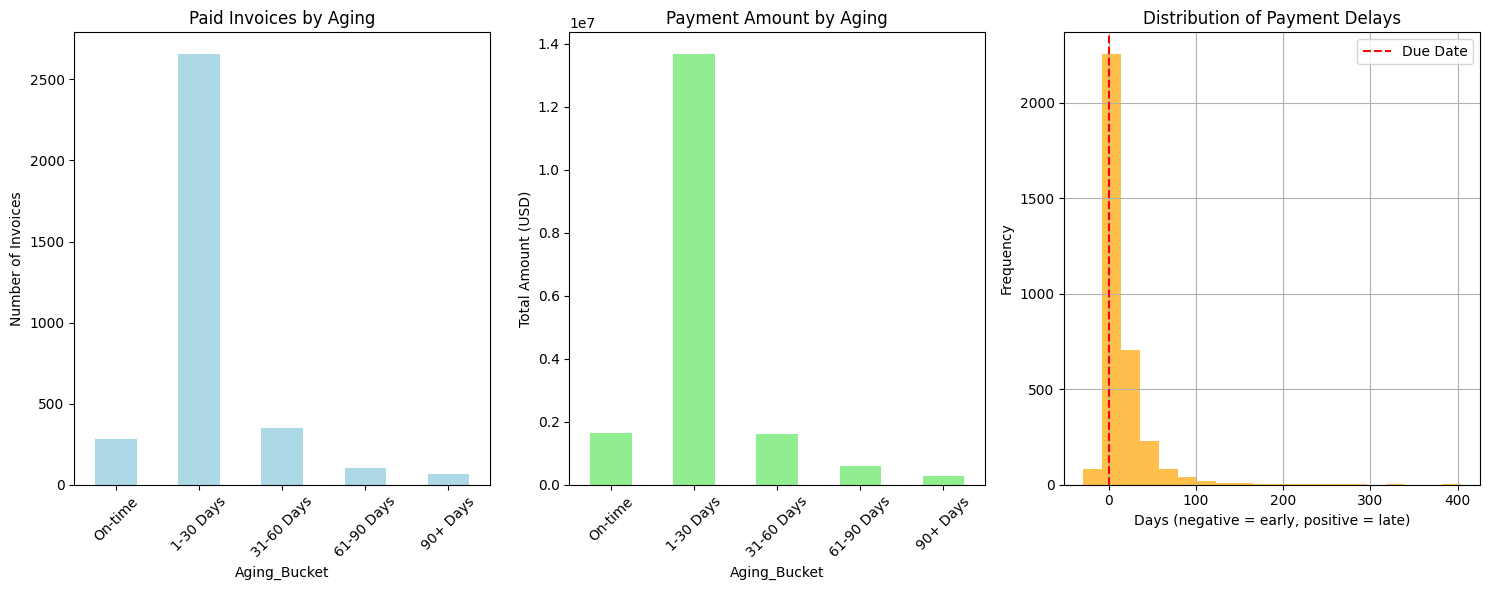


⏳ OUTSTANDING INVOICES AGING ANALYSIS
(Current collection priorities as of June 23, 2025)

Outstanding Invoices Aging Summary:
              Invoice_Count  Total_Amount  Total_Due  Avg_Days_Overdue  \
Aging_Bucket                                                             
Current                  53     203683.32  203683.32            -26.34   
1-30 Days                97     382851.66  382851.66             12.06   
31-60 Days               46     192180.68  192180.68             47.09   
61-90 Days               19      61819.90   61819.90             75.47   
90+ Days                 30      82536.46   82536.46            264.00   

              Max_Days_Overdue  Percentage  
Aging_Bucket                                
Current                     -1       21.63  
1-30 Days                   30       39.59  
31-60 Days                  60       18.78  
61-90 Days                  85        7.76  
90+ Days                   490       12.24  

🚨 COLLECTION PRIORITIES:
   Total Out

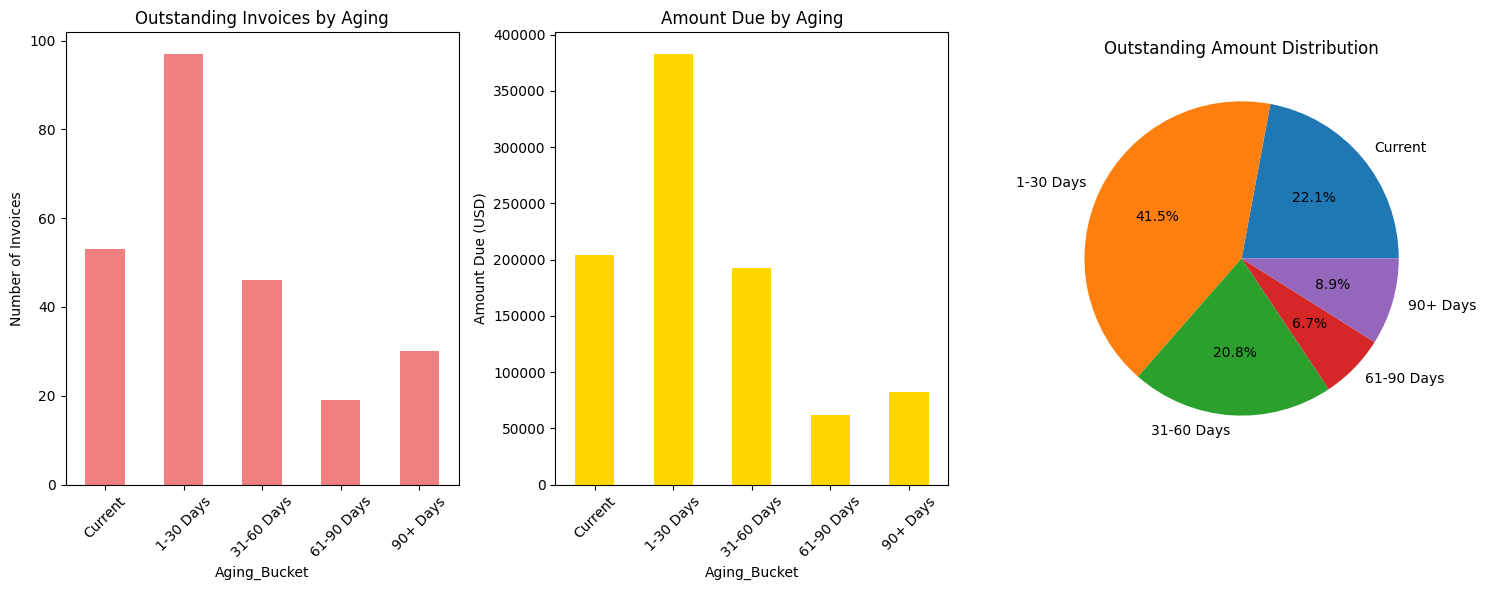


📋 EXECUTIVE SUMMARY
Portfolio Overview:
  Total Invoices: 3697
  Total Billed: $18,685,824.65
  Total Collected: $17,738,911.25
  Collection Rate: 94.9%
  Outstanding Amount: $923,072.02

Payment Behavior:
  Average Payment Delay: 16.7 days
  On-time Payment Rate: 8.1%

Current Collection Risks:
  90+ Days Overdue: 30 invoices
  High Risk Amount: $82,536.46 (8.9%)

📌 KEY RECOMMENDATIONS:
• Review credit terms - payment delays are elevated
• Excellent collection performance - maintain current procedures

🎉 ANALYSIS COMPLETED!


In [5]:
# 🚀 INITIALIZE AND RUN ANALYSIS
print("🏢 INITIALIZING FACTORING ANALYZER...")

# Initialize the analyzer
analyzer = CorrectedFactoringAnalyzer('../data/TecnoCargoInvoiceDataset01.csv', encoding='latin1')

print("\n🚀 RUNNING COMPLETE ANALYSIS...")
# Run the complete analysis
results = analyzer.run_full_analysis()

print("\n🎉 ANALYSIS COMPLETED!")

In [6]:
"""
📄 Professional PDF Report Generator for Factoring Risk Analysis
Creates a comprehensive PDF report with all analysis results, tables, and figures
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

def generate_factoring_pdf_report(analyzer, results, output_filename='Factoring_Risk_Analysis_Report.pdf'):
    """
    Generate a comprehensive PDF report for factoring risk analysis
    
    Parameters:
    analyzer: CorrectedFactoringAnalyzer instance
    results: Results dictionary from run_full_analysis()
    output_filename: Name of the output PDF file
    """
    
    print("📄 GENERATING COMPREHENSIVE PDF REPORT")
    print("="*60)
    
    # Set up the PDF file
    output_path = f'../data/{output_filename}'
    
    with PdfPages(output_path) as pdf:
        
        # Configure matplotlib for better PDF output
        plt.style.use('default')
        sns.set_palette("husl")
        
        # PAGE 1: COVER PAGE
        print("   📝 Creating cover page...")
        create_cover_page(pdf, analyzer, results)
        
        # PAGE 2: EXECUTIVE SUMMARY
        print("   📊 Creating executive summary...")
        create_executive_summary_page(pdf, analyzer, results)
        
        # PAGE 3: PORTFOLIO OVERVIEW
        print("   📈 Creating portfolio overview...")
        create_portfolio_overview_page(pdf, analyzer, results)
        
        # PAGE 4: PAID INVOICES ANALYSIS
        print("   💰 Creating paid invoices analysis...")
        create_paid_invoices_analysis_page(pdf, analyzer, results)
        
        # PAGE 5: OUTSTANDING INVOICES ANALYSIS
        print("   ⏳ Creating outstanding invoices analysis...")
        create_outstanding_invoices_analysis_page(pdf, analyzer, results)
        
        # PAGE 6: RISK ASSESSMENT
        print("   🚨 Creating risk assessment...")
        create_risk_assessment_page(pdf, analyzer, results)
        
        # PAGE 7: CLIENT ANALYSIS
        print("   👥 Creating client analysis...")
        create_client_analysis_page(pdf, analyzer, results)
        
        # PAGE 8: RECOMMENDATIONS
        print("   📌 Creating recommendations...")
        create_recommendations_page(pdf, analyzer, results)
        
        # PAGE 9: DETAILED TABLES
        print("   📋 Creating detailed tables...")
        create_detailed_tables_page(pdf, analyzer, results)
        
        # Add metadata
        pdf_metadata = pdf.infodict()
        pdf_metadata['Title'] = 'Factoring Risk Analysis Report'
        pdf_metadata['Author'] = 'Factoring Analysis System'
        pdf_metadata['Subject'] = 'Invoice Portfolio Risk Assessment'
        pdf_metadata['Creator'] = 'Python Factoring Analyzer'
        pdf_metadata['CreationDate'] = datetime.now()
    
    print(f"✅ PDF report generated: {output_path}")
    return output_path

def create_cover_page(pdf, analyzer, results):
    """Create the cover page"""
    fig, ax = plt.subplots(figsize=(8.5, 11))
    ax.axis('off')
    
    # Title
    ax.text(0.5, 0.85, 'FACTORING RISK ANALYSIS', 
            fontsize=28, weight='bold', ha='center', va='center')
    ax.text(0.5, 0.8, 'Invoice Portfolio Assessment Report', 
            fontsize=18, ha='center', va='center', style='italic')
    
    # Key metrics box
    exec_summary = results['executive_summary']
    
    # Create a summary box
    summary_text = f"""
PORTFOLIO SUMMARY
{'='*50}

Total Invoices Analyzed: {len(analyzer.df_invoice):,}
Collection Rate: {exec_summary['collection_rate']:.1f}%
Average Payment Delay: {exec_summary['avg_payment_delay']:.1f} days
Total Outstanding: ${exec_summary['total_outstanding']:,.2f}
Risk Level (90+ days): {exec_summary['risk_percentage']:.1f}%

Analysis Period: January 2024 - June 2025
Report Date: {datetime.now().strftime('%B %d, %Y')}
Data Snapshot: June 23, 2025
"""
    
    ax.text(0.5, 0.55, summary_text, fontsize=12, ha='center', va='center',
            bbox=dict(boxstyle="round,pad=1", facecolor="lightblue", alpha=0.8))
    
    # Risk assessment indicator
    risk_level = "LOW" if exec_summary['risk_percentage'] < 10 else "MODERATE" if exec_summary['risk_percentage'] < 20 else "HIGH"
    risk_color = "green" if risk_level == "LOW" else "orange" if risk_level == "MODERATE" else "red"
    
    ax.text(0.5, 0.25, f'OVERALL RISK LEVEL: {risk_level}', 
            fontsize=20, weight='bold', ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.5", facecolor=risk_color, alpha=0.7))
    
    # Footer
    ax.text(0.5, 0.1, 'CONFIDENTIAL - For Internal Use Only', 
            fontsize=10, ha='center', va='center', style='italic', alpha=0.7)
    
    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

def create_executive_summary_page(pdf, analyzer, results):
    """Create executive summary page"""
    fig = plt.figure(figsize=(8.5, 11))
    
    # Title
    fig.suptitle('EXECUTIVE SUMMARY', fontsize=20, weight='bold', y=0.95)
    
    exec_summary = results['executive_summary']
    
    # Create 4 subplots for key metrics
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1.5], hspace=0.4, wspace=0.3)
    
    # Key Performance Indicators
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.pie([exec_summary['collection_rate'], 100-exec_summary['collection_rate']], 
           labels=['Collected', 'Outstanding'], autopct='%1.1f%%', 
           colors=['lightgreen', 'lightcoral'])
    ax1.set_title('Collection Rate', weight='bold')
    
    ax2 = fig.add_subplot(gs[0, 1])
    payment_delay = exec_summary['avg_payment_delay']
    colors = ['green' if payment_delay < 15 else 'orange' if payment_delay < 30 else 'red']
    ax2.bar(['Avg Payment Delay'], [payment_delay], color=colors)
    ax2.set_ylabel('Days')
    ax2.set_title('Payment Delay Performance', weight='bold')
    
    # Risk breakdown
    ax3 = fig.add_subplot(gs[1, :])
    if results['outstanding_invoices_aging'] is not None:
        outstanding_aging = results['outstanding_invoices_aging']
        ax3.bar(outstanding_aging.index, outstanding_aging['Invoice_Count'], 
               color=['green', 'yellow', 'orange', 'red', 'darkred'])
        ax3.set_title('Outstanding Invoices by Risk Category', weight='bold')
        ax3.set_ylabel('Number of Invoices')
        plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
    
    # Key findings text
    ax4 = fig.add_subplot(gs[2, :])
    ax4.axis('off')
    
    findings_text = f"""
KEY FINDINGS & INSIGHTS

Portfolio Health: {'EXCELLENT' if exec_summary['collection_rate'] > 90 else 'GOOD' if exec_summary['collection_rate'] > 80 else 'NEEDS IMPROVEMENT'}
• Collection rate of {exec_summary['collection_rate']:.1f}% {'exceeds' if exec_summary['collection_rate'] > 90 else 'meets' if exec_summary['collection_rate'] > 80 else 'falls below'} industry standards
• Average payment delay of {exec_summary['avg_payment_delay']:.1f} days is {'excellent' if exec_summary['avg_payment_delay'] < 15 else 'acceptable' if exec_summary['avg_payment_delay'] < 30 else 'concerning'}

Risk Assessment: {exec_summary['risk_percentage']:.1f}% of outstanding amount is 90+ days overdue
• Total outstanding amount: ${exec_summary['total_outstanding']:,.2f}
• Portfolio size: {len(analyzer.df_invoice):,} total invoices
• Paid invoices: {len(analyzer.df_paid_invoices):,} ({len(analyzer.df_paid_invoices)/len(analyzer.df_invoice)*100:.1f}%)
• Outstanding invoices: {len(analyzer.df_outstanding_invoices):,} ({len(analyzer.df_outstanding_invoices)/len(analyzer.df_invoice)*100:.1f}%)

Liquidity Position: {'Strong' if len(analyzer.df_outstanding_invoices)/len(analyzer.df_invoice) < 0.15 else 'Moderate' if len(analyzer.df_outstanding_invoices)/len(analyzer.df_invoice) < 0.25 else 'Weak'}
• Low percentage of outstanding invoices indicates strong cash conversion
• Payment behavior shows {'consistent' if exec_summary['avg_payment_delay'] < 20 else 'variable'} customer payment patterns
"""
    
    ax4.text(0.05, 0.95, findings_text, fontsize=11, ha='left', va='top', 
            transform=ax4.transAxes, 
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))
    
    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

def create_portfolio_overview_page(pdf, analyzer, results):
    """Create portfolio overview page"""
    fig = plt.figure(figsize=(8.5, 11))
    fig.suptitle('PORTFOLIO OVERVIEW', fontsize=20, weight='bold', y=0.95)
    
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1], hspace=0.4, wspace=0.3)
    
    # Monthly invoice volume (if possible to extract)
    ax1 = fig.add_subplot(gs[0, :])
    if 'Transaction Date' in analyzer.df_invoice.columns:
        monthly_volume = analyzer.df_invoice.groupby(analyzer.df_invoice['Transaction Date'].dt.to_period('M')).size()
        monthly_volume.plot(kind='line', ax=ax1, marker='o')
        ax1.set_title('Monthly Invoice Volume Trend', weight='bold')
        ax1.set_ylabel('Number of Invoices')
        ax1.tick_params(axis='x', rotation=45)
    
    # Amount distribution
    ax2 = fig.add_subplot(gs[1, 0])
    analyzer.df_invoice['Amount (USD)'].hist(bins=20, ax=ax2, alpha=0.7, color='skyblue')
    ax2.set_title('Invoice Amount Distribution', weight='bold')
    ax2.set_xlabel('Amount (USD)')
    ax2.set_ylabel('Frequency')
    
    # Payment status overview
    ax3 = fig.add_subplot(gs[1, 1])
    status_counts = [len(analyzer.df_paid_invoices), len(analyzer.df_outstanding_invoices)]
    labels = ['Paid', 'Outstanding']
    colors = ['lightgreen', 'lightcoral']
    ax3.pie(status_counts, labels=labels, autopct='%1.1f%%', colors=colors)
    ax3.set_title('Payment Status Distribution', weight='bold')
    
    # Summary statistics table
    ax4 = fig.add_subplot(gs[2, :])
    ax4.axis('off')
    
    summary_stats = pd.DataFrame({
        'Metric': [
            'Total Invoices',
            'Total Billed Amount',
            'Total Collected',
            'Total Outstanding',
            'Average Invoice Amount',
            'Largest Invoice',
            'Smallest Invoice',
            'Collection Rate'
        ],
        'Value': [
            f"{len(analyzer.df_invoice):,}",
            f"${analyzer.df_invoice['Amount (USD)'].sum():,.2f}",
            f"${analyzer.df_invoice['Amt. Paid (USD)'].sum():,.2f}",
            f"${analyzer.df_outstanding_invoices['Amt. Due (USD)'].sum():,.2f}" if len(analyzer.df_outstanding_invoices) > 0 else "$0.00",
            f"${analyzer.df_invoice['Amount (USD)'].mean():,.2f}",
            f"${analyzer.df_invoice['Amount (USD)'].max():,.2f}",
            f"${analyzer.df_invoice['Amount (USD)'].min():,.2f}",
            f"{results['executive_summary']['collection_rate']:.1f}%"
        ]
    })
    
    table = ax4.table(cellText=summary_stats.values, colLabels=summary_stats.columns,
                     cellLoc='left', loc='center', colWidths=[0.4, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    ax4.set_title('Portfolio Summary Statistics', weight='bold', pad=20)
    
    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

def create_paid_invoices_analysis_page(pdf, analyzer, results):
    """Create paid invoices analysis page"""
    if results['paid_invoices_aging'] is None or len(analyzer.df_paid_invoices) == 0:
        return
        
    fig = plt.figure(figsize=(8.5, 11))
    fig.suptitle('PAID INVOICES ANALYSIS', fontsize=20, weight='bold', y=0.95)
    
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1], hspace=0.4, wspace=0.3)
    
    paid_aging = results['paid_invoices_aging']
    
    # Payment delay distribution
    ax1 = fig.add_subplot(gs[0, :])
    paid_aging['Invoice_Count'].plot(kind='bar', ax=ax1, color='lightblue')
    ax1.set_title('Payment Delay Distribution', weight='bold')
    ax1.set_ylabel('Number of Invoices')
    ax1.tick_params(axis='x', rotation=45)
    
    # Average delay by category
    ax2 = fig.add_subplot(gs[1, 0])
    paid_aging['Avg_Days_Late'].plot(kind='bar', ax=ax2, color='orange')
    ax2.set_title('Average Days Late by Category', weight='bold')
    ax2.set_ylabel('Days')
    ax2.tick_params(axis='x', rotation=45)
    
    # Amount by aging category
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.pie(paid_aging['Total_Amount'], labels=paid_aging.index, autopct='%1.1f%%')
    ax3.set_title('Amount Distribution by Aging', weight='bold')
    
    # Detailed statistics table
    ax4 = fig.add_subplot(gs[2, :])
    ax4.axis('off')
    
    # Prepare table data
    table_data = paid_aging.reset_index()
    table = ax4.table(cellText=table_data.values, colLabels=table_data.columns,
                     cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    ax4.set_title('Detailed Paid Invoices Aging Statistics', weight='bold', pad=20)
    
    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

def create_outstanding_invoices_analysis_page(pdf, analyzer, results):
    """Create outstanding invoices analysis page"""
    if results['outstanding_invoices_aging'] is None or len(analyzer.df_outstanding_invoices) == 0:
        return
        
    fig = plt.figure(figsize=(8.5, 11))
    fig.suptitle('OUTSTANDING INVOICES ANALYSIS', fontsize=20, weight='bold', y=0.95)
    
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1], hspace=0.4, wspace=0.3)
    
    outstanding_aging = results['outstanding_invoices_aging']
    
    # Outstanding by aging category
    ax1 = fig.add_subplot(gs[0, 0])
    outstanding_aging['Invoice_Count'].plot(kind='bar', ax=ax1, 
                                          color=['green', 'yellow', 'orange', 'red', 'darkred'])
    ax1.set_title('Outstanding Invoices by Category', weight='bold')
    ax1.set_ylabel('Number of Invoices')
    ax1.tick_params(axis='x', rotation=45)
    
    # Amount due by category
    ax2 = fig.add_subplot(gs[0, 1])
    outstanding_aging['Total_Due'].plot(kind='bar', ax=ax2,
                                       color=['green', 'yellow', 'orange', 'red', 'darkred'])
    ax2.set_title('Amount Due by Category', weight='bold')
    ax2.set_ylabel('Amount Due (USD)')
    ax2.tick_params(axis='x', rotation=45)
    
    # Risk distribution pie chart
    ax3 = fig.add_subplot(gs[1, :])
    ax3.pie(outstanding_aging['Total_Due'], labels=outstanding_aging.index, 
           autopct='%1.1f%%', colors=['green', 'yellow', 'orange', 'red', 'darkred'])
    ax3.set_title('Outstanding Amount Risk Distribution', weight='bold')
    
    # Detailed statistics table
    ax4 = fig.add_subplot(gs[2, :])
    ax4.axis('off')
    
    table_data = outstanding_aging.reset_index()
    table = ax4.table(cellText=table_data.values, colLabels=table_data.columns,
                     cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    ax4.set_title('Detailed Outstanding Invoices Statistics', weight='bold', pad=20)
    
    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

def create_risk_assessment_page(pdf, analyzer, results):
    """Create risk assessment page"""
    fig = plt.figure(figsize=(8.5, 11))
    fig.suptitle('RISK ASSESSMENT', fontsize=20, weight='bold', y=0.95)
    
    exec_summary = results['executive_summary']
    
    # Risk level indicator
    ax1 = fig.add_subplot(3, 1, 1)
    ax1.axis('off')
    
    risk_level = "LOW" if exec_summary['risk_percentage'] < 10 else "MODERATE" if exec_summary['risk_percentage'] < 20 else "HIGH"
    risk_color = "green" if risk_level == "LOW" else "orange" if risk_level == "MODERATE" else "red"
    
    ax1.text(0.5, 0.5, f'OVERALL RISK LEVEL: {risk_level}', 
            fontsize=24, weight='bold', ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.5", facecolor=risk_color, alpha=0.7),
            transform=ax1.transAxes)
    
    # Risk factors analysis
    ax2 = fig.add_subplot(3, 2, 3)
    risk_factors = ['Collection Rate', 'Payment Delay', '90+ Days Risk', 'Portfolio Size']
    risk_scores = [
        100 - exec_summary['collection_rate'],  # Higher collection rate = lower risk
        min(exec_summary['avg_payment_delay'] * 2, 100),  # Higher delay = higher risk
        exec_summary['risk_percentage'],  # Direct risk percentage
        min(len(analyzer.df_outstanding_invoices) / 100, 100)  # More outstanding = higher risk
    ]
    
    colors = ['green' if score < 20 else 'yellow' if score < 40 else 'orange' if score < 60 else 'red' for score in risk_scores]
    ax2.barh(risk_factors, risk_scores, color=colors)
    ax2.set_title('Risk Factor Analysis', weight='bold')
    ax2.set_xlabel('Risk Score')
    
    # Concentration risk
    ax3 = fig.add_subplot(3, 2, 4)
    if len(analyzer.df_outstanding_invoices) > 0:
        client_concentration = analyzer.df_outstanding_invoices.groupby('Applied to')['Amt. Due (USD)'].sum().sort_values(ascending=False).head(10)
        client_concentration.plot(kind='bar', ax=ax3, color='lightcoral')
        ax3.set_title('Top 10 Client Concentration Risk', weight='bold')
        ax3.set_ylabel('Amount Due (USD)')
        ax3.tick_params(axis='x', rotation=45)
    
    # Risk summary text
    ax4 = fig.add_subplot(3, 1, 3)
    ax4.axis('off')
    
    risk_text = f"""
RISK ASSESSMENT SUMMARY

Primary Risk Factors:
• 90+ Day Receivables: {exec_summary['risk_percentage']:.1f}% of outstanding amount
• Collection Efficiency: {exec_summary['collection_rate']:.1f}% overall collection rate
• Payment Delays: {exec_summary['avg_payment_delay']:.1f} days average delay
• Portfolio Liquidity: {len(analyzer.df_outstanding_invoices)/len(analyzer.df_invoice)*100:.1f}% outstanding ratio

Risk Mitigation Status:
{'✅ LOW RISK: Portfolio shows strong collection performance' if risk_level == 'LOW' else 
 '⚠️ MODERATE RISK: Monitor closely and implement preventive measures' if risk_level == 'MODERATE' else
 '🚨 HIGH RISK: Immediate action required to address collection issues'}

Recommended Actions:
• {'Continue current collection procedures' if risk_level == 'LOW' else 'Implement enhanced collection procedures' if risk_level == 'MODERATE' else 'Urgent collection intervention required'}
• {'Monitor for any deterioration' if risk_level == 'LOW' else 'Weekly risk monitoring' if risk_level == 'MODERATE' else 'Daily risk monitoring'}
• {'Maintain credit policies' if risk_level == 'LOW' else 'Review credit policies' if risk_level == 'MODERATE' else 'Tighten credit policies immediately'}
"""
    
    ax4.text(0.05, 0.95, risk_text, fontsize=11, ha='left', va='top',
            transform=ax4.transAxes,
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))
    
    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

def create_client_analysis_page(pdf, analyzer, results):
    """Create client analysis page"""
    fig = plt.figure(figsize=(8.5, 11))
    fig.suptitle('CLIENT ANALYSIS', fontsize=20, weight='bold', y=0.95)
    
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1], hspace=0.4, wspace=0.3)
    
    # Top clients by amount
    ax1 = fig.add_subplot(gs[0, 0])
    top_clients = analyzer.df_invoice.groupby('Applied to')['Amount (USD)'].sum().sort_values(ascending=False).head(10)
    top_clients.plot(kind='barh', ax=ax1, color='lightblue')
    ax1.set_title('Top 10 Clients by Total Amount', weight='bold')
    ax1.set_xlabel('Total Amount (USD)')
    
    # Client payment performance
    ax2 = fig.add_subplot(gs[0, 1])
    if len(analyzer.df_paid_invoices) > 0:
        client_performance = analyzer.df_paid_invoices.groupby('Applied to')['Aging_Delay'].mean().sort_values().head(10)
        colors = ['green' if delay <= 0 else 'yellow' if delay <= 15 else 'orange' if delay <= 30 else 'red' for delay in client_performance.values]
        client_performance.plot(kind='barh', ax=ax2, color=colors)
        ax2.set_title('Top 10 Clients by Payment Speed', weight='bold')
        ax2.set_xlabel('Average Payment Delay (Days)')
    
    # Risk clients
    ax3 = fig.add_subplot(gs[1, :])
    if len(analyzer.df_outstanding_invoices) > 0:
        risk_clients = analyzer.df_outstanding_invoices.groupby('Applied to')['Amt. Due (USD)'].sum().sort_values(ascending=False).head(10)
        risk_clients.plot(kind='bar', ax=ax3, color='lightcoral')
        ax3.set_title('Top 10 Clients by Outstanding Amount (Risk)', weight='bold')
        ax3.set_ylabel('Outstanding Amount (USD)')
        ax3.tick_params(axis='x', rotation=45)
    
    # Client summary statistics
    ax4 = fig.add_subplot(gs[2, :])
    ax4.axis('off')
    
    client_stats = analyzer.df_invoice.groupby('Applied to').agg({
        'Number': 'count',
        'Amount (USD)': ['sum', 'mean'],
        'Amt. Paid (USD)': 'sum',
        'Amt. Due (USD)': 'sum'
    }).round(2)
    
    client_stats.columns = ['Invoice_Count', 'Total_Amount', 'Avg_Amount', 'Total_Paid', 'Total_Due']
    client_stats['Collection_Rate'] = (client_stats['Total_Paid'] / client_stats['Total_Amount'] * 100).round(1)
    
    # Show top 10 clients
    top_client_stats = client_stats.sort_values('Total_Amount', ascending=False).head(10)
    
    table = ax4.table(cellText=top_client_stats.values, 
                     rowLabels=top_client_stats.index,
                     colLabels=top_client_stats.columns,
                     cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)
    ax4.set_title('Top 10 Clients - Detailed Statistics', weight='bold', pad=20)
    
    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

def create_recommendations_page(pdf, analyzer, results):
    """Create recommendations page"""
    fig, ax = plt.subplots(figsize=(8.5, 11))
    ax.axis('off')
    
    exec_summary = results['executive_summary']
    
    # Title
    ax.text(0.5, 0.95, 'RECOMMENDATIONS & ACTION PLAN', 
            fontsize=20, weight='bold', ha='center', va='top')
    
    # Generate recommendations based on analysis
    recommendations = []
    
    # Collection rate recommendations
    if exec_summary['collection_rate'] > 90:
        recommendations.append("✅ COLLECTION EFFICIENCY: Excellent performance - maintain current procedures")
    elif exec_summary['collection_rate'] > 80:
        recommendations.append("⚠️ COLLECTION EFFICIENCY: Good but can improve - review slow-paying accounts")
    else:
        recommendations.append("🚨 COLLECTION EFFICIENCY: Poor performance - immediate intervention required")
    
    # Payment delay recommendations
    if exec_summary['avg_payment_delay'] < 15:
        recommendations.append("✅ PAYMENT TIMING: Excellent payment behavior - maintain credit terms")
    elif exec_summary['avg_payment_delay'] < 30:
        recommendations.append("⚠️ PAYMENT TIMING: Acceptable delays - monitor for deterioration")
    else:
        recommendations.append("🚨 PAYMENT TIMING: Excessive delays - review credit policies and terms")
    
    # Risk level recommendations
    if exec_summary['risk_percentage'] < 10:
        recommendations.append("✅ RISK LEVEL: Low risk portfolio - maintain monitoring")
    elif exec_summary['risk_percentage'] < 20:
        recommendations.append("⚠️ RISK LEVEL: Moderate risk - implement enhanced collection procedures")
    else:
        recommendations.append("🚨 RISK LEVEL: High risk - urgent collection action required")
    
    # Specific action items
    action_items = [
        "IMMEDIATE ACTIONS (0-30 days):",
        "• Focus collection efforts on 90+ day receivables",
        "• Contact top 10 outstanding clients for payment plans",
        "• Review and update credit policies if risk is elevated",
        "",
        "SHORT-TERM ACTIONS (30-90 days):",
        "• Implement weekly aging reports",
        "• Establish client payment performance scorecards", 
        "• Consider offering early payment discounts",
        "",
        "LONG-TERM STRATEGY (90+ days):",
        "• Regular portfolio risk assessment (monthly)",
        "• Client credit limit reviews based on payment history",
        "• Implement automated collection procedures",
        "",
        "MONITORING & REPORTING:",
        "• Weekly aging reports for collections team",
        "• Monthly executive dashboard with key metrics",
        "• Quarterly portfolio risk assessment",
        "• Annual credit policy review"
    ]
    
    # Combine recommendations and action items
    full_text = "\n".join(recommendations) + "\n\n" + "\n".join(action_items)
    
    ax.text(0.05, 0.85, full_text, fontsize=11, ha='left', va='top',
            bbox=dict(boxstyle="round,pad=1", facecolor="lightgreen", alpha=0.3))
    
    # Add a priority matrix
    ax.text(0.05, 0.25, 
            "PRIORITY MATRIX:\n\n" +
            "HIGH PRIORITY: 90+ day receivables, large outstanding amounts\n" +
            "MEDIUM PRIORITY: 60-90 day receivables, repeat late payers\n" +
            "LOW PRIORITY: Current and 1-30 day receivables\n\n" +
            "Success will be measured by:\n" +
            "• Reduction in 90+ day receivables\n" +
            "• Improvement in overall collection rate\n" +
            "• Decrease in average payment delays\n" +
            "• Maintenance of strong client relationships",
            fontsize=11, ha='left', va='top',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))
    
    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

def create_detailed_tables_page(pdf, analyzer, results):
    """Create detailed tables page"""
    fig = plt.figure(figsize=(8.5, 11))
    fig.suptitle('DETAILED DATA TABLES', fontsize=20, weight='bold', y=0.95)
    
    gs = fig.add_gridspec(2, 1, height_ratios=[1, 1], hspace=0.3)
    
    # Paid invoices aging table
    ax1 = fig.add_subplot(gs[0])
    ax1.axis('off')
    if results['paid_invoices_aging'] is not None:
        paid_data = results['paid_invoices_aging'].reset_index()
        table1 = ax1.table(cellText=paid_data.values, colLabels=paid_data.columns,
                          cellLoc='center', loc='center')
        table1.auto_set_font_size(False)
        table1.set_fontsize(10)
        table1.scale(1, 2)
        ax1.set_title('Paid Invoices Aging - Detailed Statistics', weight='bold', pad=20)
    
    # Outstanding invoices aging table  
    ax2 = fig.add_subplot(gs[1])
    ax2.axis('off')
    if results['outstanding_invoices_aging'] is not None:
        outstanding_data = results['outstanding_invoices_aging'].reset_index()
        table2 = ax2.table(cellText=outstanding_data.values, colLabels=outstanding_data.columns,
                          cellLoc='center', loc='center')
        table2.auto_set_font_size(False)
        table2.set_fontsize(10)
        table2.scale(1, 2)
        ax2.set_title('Outstanding Invoices Aging - Detailed Statistics', weight='bold', pad=20)
    
    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

# Main function to generate report
def create_complete_factoring_report(analyzer, results, filename='Factoring_Risk_Analysis_Report.pdf'):
    """
    Main function to create the complete PDF report
    
    Usage:
    # After running your analysis:
    report_path = create_complete_factoring_report(analyzer, results)
    """
    
    return generate_factoring_pdf_report(analyzer, results, filename)

print("✅ PDF Report Generator loaded successfully!")
print("📄 Ready to generate comprehensive factoring risk analysis report!")

# 📄 STEP 2: INSTALL REQUIRED PACKAGE (if needed)
import subprocess
import sys

try:
    import matplotlib
    print("✅ Matplotlib already installed")
except ImportError:
    print("Installing matplotlib...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib"])

# 📄 STEP 3: GENERATE THE COMPLETE PDF REPORT
print("📄 GENERATING COMPREHENSIVE PDF REPORT...")
print("="*60)

# Generate the PDF report (make sure you have run the analysis first)
report_path = create_complete_factoring_report(
    analyzer=analyzer,  # Your analyzer instance
    results=results,    # Your analysis results
    filename='TecnoCargo_Factoring_Risk_Analysis_Report.pdf'
)

print(f"🎉 SUCCESS!")
print(f"📁 PDF Report saved to: {report_path}")
print(f"📊 Report contains 9 comprehensive pages with all analysis results!")

✅ PDF Report Generator loaded successfully!
📄 Ready to generate comprehensive factoring risk analysis report!
✅ Matplotlib already installed
📄 GENERATING COMPREHENSIVE PDF REPORT...
📄 GENERATING COMPREHENSIVE PDF REPORT
   📝 Creating cover page...
   📊 Creating executive summary...
   📈 Creating portfolio overview...
   💰 Creating paid invoices analysis...
   ⏳ Creating outstanding invoices analysis...
   🚨 Creating risk assessment...
   👥 Creating client analysis...
   📌 Creating recommendations...
   📋 Creating detailed tables...
✅ PDF report generated: ../data/TecnoCargo_Factoring_Risk_Analysis_Report.pdf
🎉 SUCCESS!
📁 PDF Report saved to: ../data/TecnoCargo_Factoring_Risk_Analysis_Report.pdf
📊 Report contains 9 comprehensive pages with all analysis results!


In [8]:
# ============================================================================
# CELL 1: Setup and Installation Check
# Add this cell to your notebooks/01_factoring_analysis.ipynb
# ============================================================================

import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path (assuming notebook is in notebooks/ folder)
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.append(str(project_root))

print(f"📁 Project root: {project_root}")
print(f"📁 Current directory: {Path.cwd()}")

# Check if required packages are installed
def check_packages():
    missing = []
    
    packages = {
        'pandas': 'pandas',
        'matplotlib': 'matplotlib',
        'weasyprint': 'weasyprint',
        'jinja2': 'jinja2',
        'seaborn': 'seaborn'
    }
    
    for name, package in packages.items():
        try:
            __import__(package)
            print(f"✅ {name} available")
        except ImportError:
            missing.append(package)
            print(f"❌ {name} missing")
    
    if missing:
        print(f"\n📦 Install missing packages with:")
        print(f"!pip install {' '.join(missing)}")
        return False
    
    print("\n✅ All packages available!")
    return True

# Check packages
packages_ok = check_packages()

# Create output directories
output_dir = project_root / 'output'
(output_dir / 'charts').mkdir(parents=True, exist_ok=True)
(output_dir / 'reports').mkdir(parents=True, exist_ok=True)
print(f"📁 Output directory ready: {output_dir}")

📁 Project root: /Users/nicolachiara/VSCODE/PROJECTS/Onboarding/python/onboardingpython01/factoring_analysis
📁 Current directory: /Users/nicolachiara/VSCODE/PROJECTS/Onboarding/python/onboardingpython01/factoring_analysis/notebooks
✅ pandas available
✅ matplotlib available
✅ weasyprint available
✅ jinja2 available
✅ seaborn available

✅ All packages available!
📁 Output directory ready: /Users/nicolachiara/VSCODE/PROJECTS/Onboarding/python/onboardingpython01/factoring_analysis/output


✅ Complete CorrectedFactoringAnalyzer class loaded successfully!
🚀 Ready to run full analysis!
🏢 INITIALIZING FACTORING ANALYZER...
✅ Data loaded successfully with latin1 encoding
🔧 Starting data preparation...
   Converting Amount (USD) to numeric...
   Converting Amt. Paid (USD) to numeric...
   Converting Amt. Due (USD) to numeric...
   ✅ Monetary columns converted
   📄 Invoice records: 3697
   📝 Credit Memo records: 69
📅 Converting date columns (MM/DD/YYYY format)...
   ✅ Date columns converted
   💰 Paid invoices: 3452
   ⏳ Outstanding invoices: 245
✅ Data preparation completed successfully!

🚀 RUNNING COMPLETE ANALYSIS...
🏢 CORRECTED FACTORING FIRM ANALYSIS

💰 PAID INVOICES AGING ANALYSIS
(How late were payments when received)

Paid Invoices Aging Summary:
              Invoice_Count  Total_Amount  Avg_Days_Late  Max_Days_Late  \
Aging_Bucket                                                              
On-time                 280    1629970.59          -5.89              0   
1-3

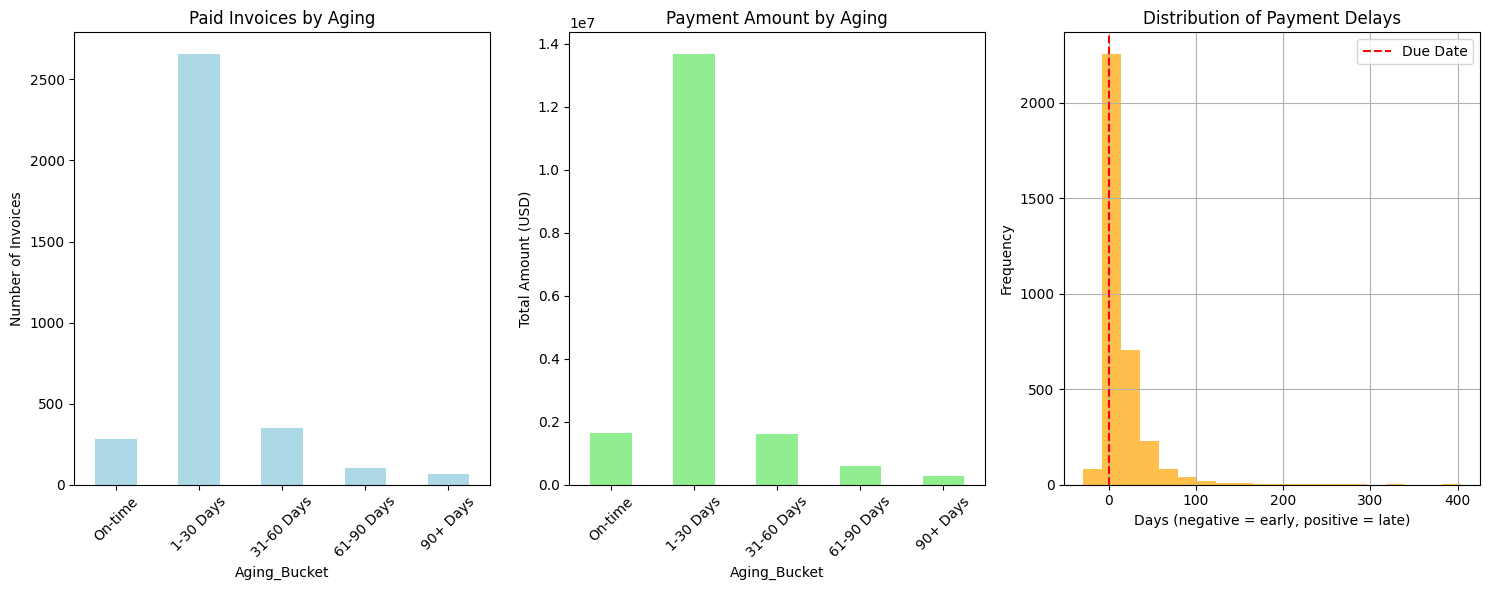


⏳ OUTSTANDING INVOICES AGING ANALYSIS
(Current collection priorities as of June 23, 2025)

Outstanding Invoices Aging Summary:
              Invoice_Count  Total_Amount  Total_Due  Avg_Days_Overdue  \
Aging_Bucket                                                             
Current                  53     203683.32  203683.32            -26.34   
1-30 Days                97     382851.66  382851.66             12.06   
31-60 Days               46     192180.68  192180.68             47.09   
61-90 Days               19      61819.90   61819.90             75.47   
90+ Days                 30      82536.46   82536.46            264.00   

              Max_Days_Overdue  Percentage  
Aging_Bucket                                
Current                     -1       21.63  
1-30 Days                   30       39.59  
31-60 Days                  60       18.78  
61-90 Days                  85        7.76  
90+ Days                   490       12.24  

🚨 COLLECTION PRIORITIES:
   Total Out

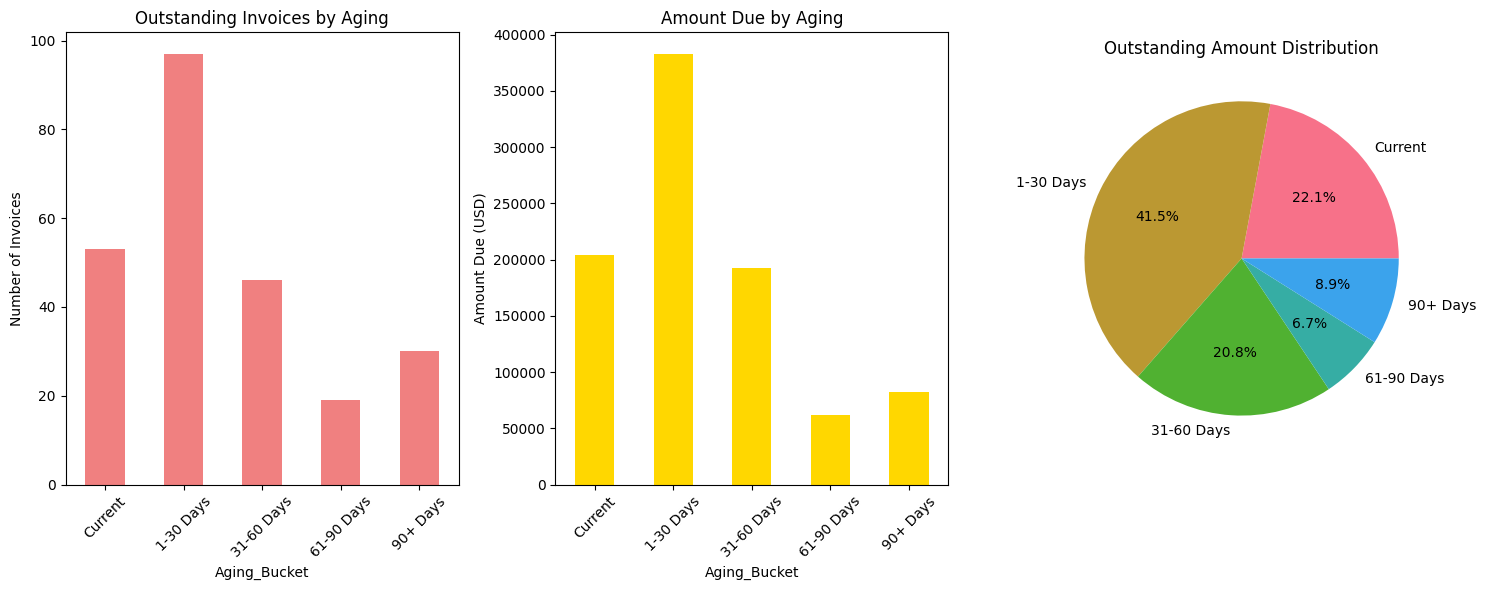


📋 EXECUTIVE SUMMARY
Portfolio Overview:
  Total Invoices: 3697
  Total Billed: $18,685,824.65
  Total Collected: $17,738,911.25
  Collection Rate: 94.9%
  Outstanding Amount: $923,072.02

Payment Behavior:
  Average Payment Delay: 16.7 days
  On-time Payment Rate: 8.1%

Current Collection Risks:
  90+ Days Overdue: 30 invoices
  High Risk Amount: $82,536.46 (8.9%)

📌 KEY RECOMMENDATIONS:
• Review credit terms - payment delays are elevated
• Excellent collection performance - maintain current procedures

🎉 ANALYSIS COMPLETED!
🏢 INITIALIZING FACTORING ANALYZER...
✅ Data loaded successfully with latin1 encoding
🔧 Starting data preparation...
   Converting Amount (USD) to numeric...
   Converting Amt. Paid (USD) to numeric...
   Converting Amt. Due (USD) to numeric...
   ✅ Monetary columns converted
   📄 Invoice records: 3697
   📝 Credit Memo records: 69
📅 Converting date columns (MM/DD/YYYY format)...
   ✅ Date columns converted
   💰 Paid invoices: 3452
   ⏳ Outstanding invoices: 245
✅ D

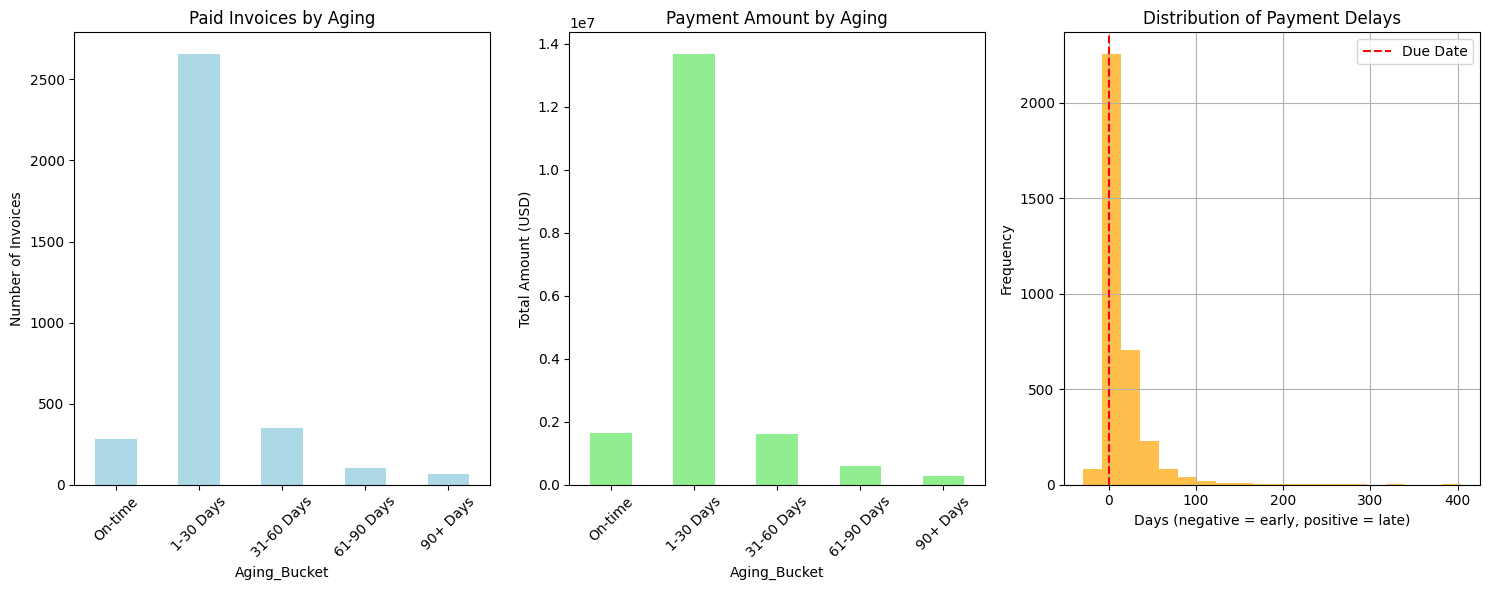


⏳ OUTSTANDING INVOICES AGING ANALYSIS
(Current collection priorities as of June 23, 2025)

Outstanding Invoices Aging Summary:
              Invoice_Count  Total_Amount  Total_Due  Avg_Days_Overdue  \
Aging_Bucket                                                             
Current                  53     203683.32  203683.32            -26.34   
1-30 Days                97     382851.66  382851.66             12.06   
31-60 Days               46     192180.68  192180.68             47.09   
61-90 Days               19      61819.90   61819.90             75.47   
90+ Days                 30      82536.46   82536.46            264.00   

              Max_Days_Overdue  Percentage  
Aging_Bucket                                
Current                     -1       21.63  
1-30 Days                   30       39.59  
31-60 Days                  60       18.78  
61-90 Days                  85        7.76  
90+ Days                   490       12.24  

🚨 COLLECTION PRIORITIES:
   Total Out

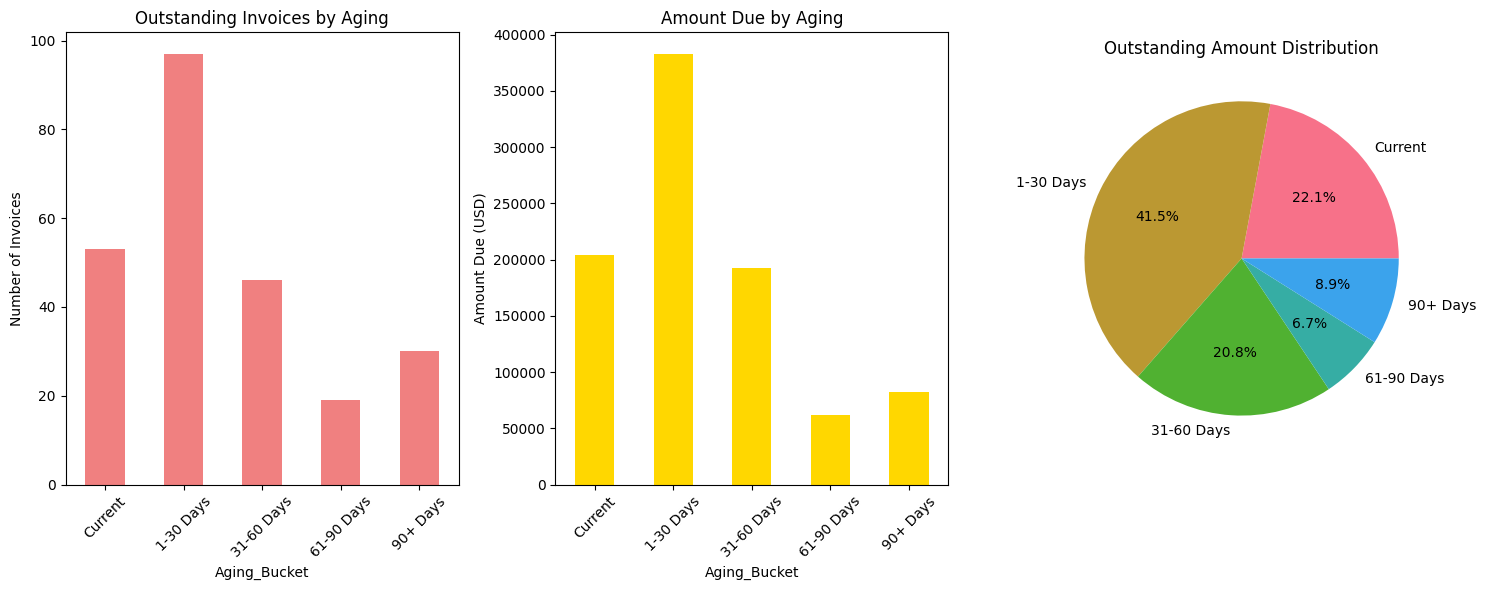


📋 EXECUTIVE SUMMARY
Portfolio Overview:
  Total Invoices: 3697
  Total Billed: $18,685,824.65
  Total Collected: $17,738,911.25
  Collection Rate: 94.9%
  Outstanding Amount: $923,072.02

Payment Behavior:
  Average Payment Delay: 16.7 days
  On-time Payment Rate: 8.1%

Current Collection Risks:
  90+ Days Overdue: 30 invoices
  High Risk Amount: $82,536.46 (8.9%)

📌 KEY RECOMMENDATIONS:
• Review credit terms - payment delays are elevated
• Excellent collection performance - maintain current procedures

✅ ANALYSIS COMPLETED!


In [9]:

# ============================================================================
# CELL 3: Import and Run Analysis (Your existing code, modified)
# ============================================================================

# Import your existing analyzer
from reports.routine_supportfor_report_v01 import CorrectedFactoringAnalyzer

# Initialize and run analysis (your existing workflow)
print("🏢 INITIALIZING FACTORING ANALYZER...")
print("="*60)

# Load data (adjust path as needed)
data_file = project_root / 'data' / 'TecnoCargoInvoiceDataset01.csv'
analyzer = CorrectedFactoringAnalyzer(str(data_file), encoding='latin1')

print("\n🚀 RUNNING COMPLETE ANALYSIS...")
print("="*60)

# Run your existing analysis
results = analyzer.run_full_analysis()

print("\n✅ ANALYSIS COMPLETED!")
print("="*60)

In [13]:
# ============================================================================
# CELL 4: Professional Report with Matplotlib (Fallback - Always Works)
# ============================================================================

print("🎨 GENERATING PROFESSIONAL REPORT (MATPLOTLIB VERSION)")
print("="*60)

from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as patches

def create_professional_matplotlib_report(analyzer, results, filename='TecnoCargo_Professional_Report.pdf'):
    output_path = project_root / 'output' / 'reports' / filename
    
    with PdfPages(str(output_path)) as pdf:
        # PAGE 1: PROFESSIONAL COVER PAGE
        fig = plt.figure(figsize=(8.5, 11))
        fig.patch.set_facecolor('white')
        ax = fig.add_subplot(111)
        ax.axis('off')
        
        # Background gradient effect
        y = np.linspace(0, 1, 100)
        X, Y = np.meshgrid(np.linspace(0, 1, 100), y)
        Z = 0.3 * np.exp(-((X-0.5)**2 + (Y-0.8)**2) / 0.1)
        ax.contourf(X, Y, Z, levels=20, cmap='Blues', alpha=0.3)
        
        # Professional title
        title_box = dict(boxstyle="round,pad=0.6", facecolor="#2E8B57", alpha=0.9, edgecolor='navy', linewidth=2)
        ax.text(0.5, 0.85, 'FACTORING RISK ANALYSIS', 
                fontsize=28, weight='bold', ha='center', va='center',
                color='white', bbox=title_box)
        
        ax.text(0.5, 0.78, 'Professional Invoice Portfolio Assessment', 
                fontsize=16, ha='center', va='center', style='italic', 
                color='#1E40AF', weight='bold')
        
        # Key metrics in professional boxes
        exec_summary = results['executive_summary']
        
        metrics = [
            ('Total Invoices', f"{len(analyzer.df_invoice):,}", '#E3F2FD'),
            ('Collection Rate', f"{exec_summary['collection_rate']:.1f}%", '#E8F5E8'),
            ('Avg Payment Delay', f"{exec_summary['avg_payment_delay']:.1f} days", '#FFF3E0'),
            ('Total Outstanding', f"${exec_summary['total_outstanding']:,.0f}", '#FCE4EC')
        ]
        
        # Create 2x2 grid for metrics
        positions = [(0.25, 0.6), (0.75, 0.6), (0.25, 0.48), (0.75, 0.48)]
        
        for (label, value, color), (x, y) in zip(metrics, positions):
            # Create styled metric box
            rect = patches.FancyBboxPatch((x-0.11, y-0.05), 0.22, 0.1,
                                         boxstyle="round,pad=0.01", 
                                         facecolor=color, edgecolor='#333', linewidth=1.5)
            ax.add_patch(rect)
            
            # Value
            ax.text(x, y+0.01, value, fontsize=14, weight='bold', 
                   ha='center', va='center', color='#1E40AF')
            # Label
            ax.text(x, y-0.025, label, fontsize=9, weight='bold',
                   ha='center', va='center', color='#333')
        
        # Risk assessment
        risk_level = "LOW" if exec_summary['risk_percentage'] < 10 else "MODERATE" if exec_summary['risk_percentage'] < 20 else "HIGH"
        risk_colors = {"LOW": "#4CAF50", "MODERATE": "#FF9800", "HIGH": "#F44336"}
        risk_color = risk_colors[risk_level]
        
        risk_box = dict(boxstyle="round,pad=0.5", facecolor=risk_color, alpha=0.9, edgecolor='#333', linewidth=2)
        ax.text(0.5, 0.3, f'OVERALL RISK LEVEL: {risk_level}', 
                fontsize=18, weight='bold', ha='center', va='center',
                color='white', bbox=risk_box)
        
        # Report details
        footer_text = f"""Analysis Period: January 2024 - June 2025
Report Generated: {datetime.now().strftime('%B %d, %Y at %I:%M %p')}
Data Snapshot: June 23, 2025
System: Professional Factoring Analysis Platform"""
        
        ax.text(0.5, 0.15, footer_text, fontsize=10, ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.4", facecolor="#F5F5F5", alpha=0.8, edgecolor='#CCC'))
        
        ax.text(0.5, 0.03, 'CONFIDENTIAL BUSINESS INFORMATION - INTERNAL USE ONLY', 
                fontsize=11, ha='center', va='center', style='italic', 
                weight='bold', color='#B71C1C')
        
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()
        
        # PAGE 2: EXECUTIVE DASHBOARD
        fig = plt.figure(figsize=(8.5, 11))
        fig.patch.set_facecolor('white')
        fig.suptitle('EXECUTIVE DASHBOARD', fontsize=22, weight='bold', color='#2E8B57', y=0.95)
        
        # Create 2x2 grid
        gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
        
        # 1. Collection Rate Donut Chart
        ax1 = fig.add_subplot(gs[0, 0])
        sizes = [exec_summary['collection_rate'], 100-exec_summary['collection_rate']]
        colors = ['#2E8B57', '#E53E3E']
        
        wedges, texts, autotexts = ax1.pie(sizes, labels=['Collected', 'Outstanding'], 
                                          autopct='%1.1f%%', colors=colors, startangle=90,
                                          pctdistance=0.85, textprops={'fontsize': 10, 'weight': 'bold'})
        
        # Create donut effect
        centre_circle = plt.Circle((0,0), 0.60, fc='white', ec='#333', linewidth=2)
        ax1.add_artist(centre_circle)
        ax1.text(0, 0, f'{exec_summary["collection_rate"]:.1f}%', 
                ha='center', va='center', fontsize=16, weight='bold', color='#2E8B57')
        ax1.text(0, -0.15, 'Collection\nRate', ha='center', va='center', 
                fontsize=10, weight='bold', color='#333')
        
        ax1.set_title('Collection Performance', weight='bold', fontsize=12, pad=15)
        
        # 2. Outstanding Aging Analysis
        ax2 = fig.add_subplot(gs[0, 1])
        if results['outstanding_invoices_aging'] is not None:
            outstanding_aging = results['outstanding_invoices_aging']
            colors = ['#28a745', '#ffc107', '#fd7e14', '#dc3545', '#6f42c1']
            
            bars = ax2.bar(outstanding_aging.index, outstanding_aging['Invoice_Count'], 
                          color=colors[:len(outstanding_aging)], alpha=0.8, edgecolor='black')
            
            # Add value labels
            for bar in bars:
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                        f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=9)
            
            ax2.set_title('Outstanding by Age Category', weight='bold', fontsize=12, pad=15)
            ax2.set_ylabel('Number of Invoices', weight='bold')
            ax2.tick_params(axis='x', rotation=45)
            ax2.grid(True, alpha=0.3, axis='y')
        
        # 3. Top Clients Analysis
        ax3 = fig.add_subplot(gs[1, 0])
        top_clients = analyzer.df_invoice.groupby('Applied to')['Amount (USD)'].sum().sort_values(ascending=False).head(8)
        
        colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_clients)))
        bars = ax3.barh(range(len(top_clients)), top_clients.values, color=colors, alpha=0.8)
        
        ax3.set_yticks(range(len(top_clients)))
        ax3.set_yticklabels([c[:20] + '...' if len(c) > 20 else c for c in top_clients.index], fontsize=9)
        ax3.set_xlabel('Total Amount (USD)', weight='bold')
        ax3.set_title('Top Clients by Amount', weight='bold', fontsize=12, pad=15)
        ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        ax3.grid(True, alpha=0.3, axis='x')
        
        # 4. Payment Delay Distribution
        ax4 = fig.add_subplot(gs[1, 1])
        if len(analyzer.df_paid_invoices) > 0:
            delays = analyzer.df_paid_invoices['Aging_Delay']
            n, bins, patches_hist = ax4.hist(delays, bins=20, alpha=0.7, edgecolor='black')
            
            # Color bars based on delay
            for i, patch in enumerate(patches_hist):
                bin_center = (bins[i] + bins[i+1]) / 2
                if bin_center <= 0:
                    patch.set_facecolor('#28a745')  # Green for early/on-time
                elif bin_center <= 30:
                    patch.set_facecolor('#ffc107')  # Yellow for slightly late
                else:
                    patch.set_facecolor('#dc3545')  # Red for very late
            
            ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Due Date')
            ax4.axvline(x=delays.mean(), color='orange', linestyle='-', linewidth=2, 
                      label=f'Avg ({delays.mean():.1f}d)')
            
            ax4.set_title('Payment Delay Distribution', weight='bold', fontsize=12, pad=15)
            ax4.set_xlabel('Days (negative = early)', weight='bold')
            ax4.set_ylabel('Number of Invoices', weight='bold')
            ax4.legend(fontsize=9)
            ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()
        
        # PAGE 3: DETAILED ANALYSIS
        if results['outstanding_invoices_aging'] is not None:
            fig = plt.figure(figsize=(8.5, 11))
            fig.patch.set_facecolor('white')
            fig.suptitle('DETAILED AGING ANALYSIS', fontsize=22, weight='bold', color='#2E8B57', y=0.95)
            
            outstanding_aging = results['outstanding_invoices_aging']
            
            # Create detailed aging charts
            gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1], hspace=0.4, wspace=0.3)
            
            # Outstanding amount by category
            ax1 = fig.add_subplot(gs[0, :])
            colors = ['#28a745', '#ffc107', '#fd7e14', '#dc3545', '#6f42c1']
            bars = ax1.bar(outstanding_aging.index, outstanding_aging['Total_Due'], 
                          color=colors[:len(outstanding_aging)], alpha=0.8, edgecolor='black')
            
            # Add value labels and percentages
            total_due = outstanding_aging['Total_Due'].sum()
            for bar, amount in zip(bars, outstanding_aging['Total_Due']):
                height = bar.get_height()
                percentage = (amount / total_due) * 100
                ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                        f'${amount:,.0f}\n({percentage:.1f}%)', 
                        ha='center', va='bottom', fontweight='bold', fontsize=10)
            
            ax1.set_title('Outstanding Amount by Age Category', weight='bold', fontsize=14, pad=20)
            ax1.set_ylabel('Amount Due (USD)', weight='bold')
            ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
            ax1.tick_params(axis='x', rotation=45)
            ax1.grid(True, alpha=0.3, axis='y')
            
            # Risk distribution pie
            ax2 = fig.add_subplot(gs[1, 0])
            wedges, texts, autotexts = ax2.pie(outstanding_aging['Total_Due'], 
                                              labels=outstanding_aging.index,
                                              autopct='%1.1f%%', 
                                              colors=colors[:len(outstanding_aging)],
                                              startangle=90)
            
            for autotext in autotexts:
                autotext.set_color('white')
                autotext.set_fontweight('bold')
                autotext.set_fontsize(10)
            
            ax2.set_title('Risk Distribution by Amount', weight='bold', fontsize=12, pad=15)
            
            # Statistics table
            ax3 = fig.add_subplot(gs[1, 1])
            ax3.axis('off')
            
            # Key statistics
            stats_text = f"""KEY STATISTICS
            
Total Outstanding: ${outstanding_aging['Total_Due'].sum():,.0f}
Number of Invoices: {outstanding_aging['Invoice_Count'].sum():,}

Risk Breakdown:
- Current: {outstanding_aging.loc['Current', 'Percentage'] if 'Current' in outstanding_aging.index else 0:.1f}%
- 90+ Days: {outstanding_aging.loc[outstanding_aging.index.str.contains('90+'), 'Percentage'].sum() if any(outstanding_aging.index.str.contains('90+')) else 0:.1f}%

Average Days Overdue: {outstanding_aging['Avg_Days_Overdue'].mean():.1f}
"""
            
            ax3.text(0.1, 0.9, stats_text, fontsize=11, ha='left', va='top',
                    transform=ax3.transAxes,
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="#f0f8ff", alpha=0.8))
            
            # Summary recommendations
            ax4 = fig.add_subplot(gs[2, :])
            ax4.axis('off')
            
            # Risk-based recommendations
            risk_percentage = exec_summary['risk_percentage']
            if risk_percentage > 20:
                recommendations = """🚨 HIGH PRIORITY ACTIONS REQUIRED:
- Immediate collection efforts on 90+ day receivables
- Daily monitoring and escalation procedures
- Review and tighten credit policies immediately
- Consider collection agency for severely overdue accounts"""
                bg_color = "#ffebee"
            elif risk_percentage > 10:
                recommendations = """⚠️ MODERATE ATTENTION NEEDED:
- Weekly focus on aging receivables
- Implement enhanced collection procedures
- Regular client payment reviews
- Consider payment plan negotiations"""
                bg_color = "#fff3e0"
            else:
                recommendations = """✅ GOOD PERFORMANCE - MAINTAIN PROCEDURES:
- Continue current collection processes
- Monthly portfolio reviews
- Maintain good client relationships
- Monitor for any deterioration trends"""
                bg_color = "#e8f5e8"
            
            ax4.text(0.05, 0.8, recommendations, fontsize=12, ha='left', va='top',
                    transform=ax4.transAxes,
                    bbox=dict(boxstyle="round,pad=0.5", facecolor=bg_color, alpha=0.8))
            
            plt.tight_layout()
            pdf.savefig(fig, bbox_inches='tight')
            plt.close()
    
    return str(output_path)

# Generate the professional report
try:
    report_path = create_professional_matplotlib_report(analyzer, results)
    print(f"✅ PROFESSIONAL REPORT GENERATED SUCCESSFULLY!")
    print(f"📄 Report location: {report_path}")
    
    # Show key metrics
    exec_summary = results['executive_summary']
    print(f"\n📊 KEY INSIGHTS:")
    print(f"   Collection Rate: {exec_summary['collection_rate']:.1f}%")
    print(f"   Average Payment Delay: {exec_summary['avg_payment_delay']:.1f} days")
    print(f"   Total Outstanding: ${exec_summary['total_outstanding']:,.2f}")
    print(f"   Risk Level (90+ days): {exec_summary['risk_percentage']:.1f}%")
    
    risk_level = "LOW" if exec_summary['risk_percentage'] < 10 else "MODERATE" if exec_summary['risk_percentage'] < 20 else "HIGH"
    print(f"   Overall Risk Assessment: {risk_level}")
    
    print(f"\n🎉 SUCCESS! Check your output/reports/ folder for the PDF!")
    
except Exception as e:
    print(f"❌ Error generating report: {e}")
    import traceback
    traceback.print_exc()

🎨 GENERATING PROFESSIONAL REPORT (MATPLOTLIB VERSION)
✅ PROFESSIONAL REPORT GENERATED SUCCESSFULLY!
📄 Report location: /Users/nicolachiara/VSCODE/PROJECTS/Onboarding/python/onboardingpython01/factoring_analysis/output/reports/TecnoCargo_Professional_Report.pdf

📊 KEY INSIGHTS:
   Collection Rate: 94.9%
   Average Payment Delay: 16.7 days
   Total Outstanding: $923,072.02
   Risk Level (90+ days): 8.9%
   Overall Risk Assessment: LOW

🎉 SUCCESS! Check your output/reports/ folder for the PDF!


In [14]:
# ============================================================================
# CELL: ReportLab Professional Report Generator + Comparison
# ============================================================================

print("📄 REPORTLAB PROFESSIONAL REPORT GENERATOR")
print("="*60)

# First, save the ReportLab report generator code
reportlab_code = '''
# Copy the entire ReportLab code from the artifact above
# Save it as: reports/reportlab_professional_report.py
'''

# For now, let's create a simplified version directly in the notebook
from datetime import datetime
import matplotlib.pyplot as plt

# Install ReportLab if needed
try:
    from reportlab.lib.pagesizes import A4
    from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer, PageBreak
    from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
    from reportlab.lib.units import inch
    from reportlab.lib.colors import HexColor, black, white
    from reportlab.lib.enums import TA_CENTER, TA_LEFT, TA_RIGHT, TA_JUSTIFY
    from reportlab.graphics.shapes import Drawing
    from reportlab.graphics.charts.piecharts import Pie
    from reportlab.graphics.charts.barcharts import VerticalBarChart
    print("✅ ReportLab available")
except ImportError:
    print("📦 Installing ReportLab...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "reportlab"])
    from reportlab.lib.pagesizes import A4
    from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer, PageBreak
    from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
    from reportlab.lib.units import inch
    from reportlab.lib.colors import HexColor, black, white
    from reportlab.lib.enums import TA_CENTER, TA_LEFT, TA_RIGHT, TA_JUSTIFY
    from reportlab.graphics.shapes import Drawing
    from reportlab.graphics.charts.piecharts import Pie
    from reportlab.graphics.charts.barcharts import VerticalBarChart

def create_reportlab_business_report(analyzer, results, filename='ReportLab_Business_Report.pdf'):
    """Create professional business report using ReportLab"""
    
    output_path = project_root / 'output' / 'reports' / filename
    
    # Corporate colors
    primary_color = HexColor('#2E8B57')    # Sea Green
    secondary_color = HexColor('#4682B4')  # Steel Blue
    success_color = HexColor('#28a745')    # Success Green
    warning_color = HexColor('#ffc107')    # Warning Yellow
    danger_color = HexColor('#dc3545')     # Danger Red
    light_gray = HexColor('#f8f9fa')       # Light Gray
    
    # Create document
    doc = SimpleDocTemplate(
        str(output_path),
        pagesize=A4,
        rightMargin=0.75*inch,
        leftMargin=0.75*inch,
        topMargin=1*inch,
        bottomMargin=1*inch,
        title="Factoring Risk Analysis Report - ReportLab Edition"
    )
    
    # Get styles and create custom ones
    styles = getSampleStyleSheet()
    
    # Corporate title style
    title_style = ParagraphStyle(
        name='CorporateTitle',
        parent=styles['Title'],
        fontSize=28,
        textColor=primary_color,
        spaceAfter=30,
        alignment=TA_CENTER,
        fontName='Helvetica-Bold'
    )
    
    # Section header style
    section_style = ParagraphStyle(
        name='SectionHeader',
        parent=styles['Heading1'],
        fontSize=18,
        textColor=primary_color,
        spaceAfter=15,
        spaceBefore=25,
        fontName='Helvetica-Bold'
    )
    
    # Body style
    body_style = ParagraphStyle(
        name='CorporateBody',
        parent=styles['Normal'],
        fontSize=11,
        textColor=black,
        spaceAfter=12,
        alignment=TA_JUSTIFY,
        fontName='Helvetica'
    )
    
    # Build story
    story = []
    exec_summary = results['executive_summary']
    
    # COVER PAGE
    story.append(Spacer(1, 0.5*inch))
    story.append(Paragraph('FACTORING RISK ANALYSIS', title_style))
    story.append(Paragraph('Professional Business Report - ReportLab Edition', styles['Heading2']))
    story.append(Spacer(1, 0.5*inch))
    
    # Key metrics table
    metrics_data = [
        ['Metric', 'Value'],
        ['Total Invoices', f"{len(analyzer.df_invoice):,}"],
        ['Collection Rate', f"{exec_summary['collection_rate']:.1f}%"],
        ['Average Payment Delay', f"{exec_summary['avg_payment_delay']:.1f} days"],
        ['Total Outstanding', f"${exec_summary['total_outstanding']:,.0f}"],
        ['Risk Level (90+ days)', f"{exec_summary['risk_percentage']:.1f}%"]
    ]
    
    metrics_table = Table(metrics_data, colWidths=[2.5*inch, 2*inch])
    metrics_table.setStyle(TableStyle([
        ('BACKGROUND', (0,0), (-1,0), primary_color),
        ('TEXTCOLOR', (0,0), (-1,0), white),
        ('FONTNAME', (0,0), (-1,0), 'Helvetica-Bold'),
        ('FONTSIZE', (0,0), (-1,0), 12),
        ('ALIGN', (0,0), (-1,-1), 'CENTER'),
        ('FONTNAME', (0,1), (-1,-1), 'Helvetica'),
        ('FONTSIZE', (0,1), (-1,-1), 11),
        ('GRID', (0,0), (-1,-1), 1, black),
        ('ROWBACKGROUNDS', (0,1), (-1,-1), [white, light_gray]),
        ('LEFTPADDING', (0,0), (-1,-1), 12),
        ('RIGHTPADDING', (0,0), (-1,-1), 12),
        ('TOPPADDING', (0,0), (-1,-1), 8),
        ('BOTTOMPADDING', (0,0), (-1,-1), 8),
    ]))
    
    story.append(metrics_table)
    story.append(Spacer(1, 0.5*inch))
    
    # Risk indicator
    risk_level = "LOW" if exec_summary['risk_percentage'] < 10 else "MODERATE" if exec_summary['risk_percentage'] < 20 else "HIGH"
    risk_color = success_color if risk_level == "LOW" else warning_color if risk_level == "MODERATE" else danger_color
    
    risk_style = ParagraphStyle(
        name='RiskIndicator',
        parent=styles['Normal'],
        fontSize=16,
        textColor=white,
        alignment=TA_CENTER,
        fontName='Helvetica-Bold',
        backColor=risk_color,
        borderWidth=2,
        borderColor=black
    )
    
    story.append(Paragraph(f'OVERALL RISK LEVEL: {risk_level}', risk_style))
    story.append(Spacer(1, 0.3*inch))
    
    # Report info
    report_info = f"""
    <para align='center'>
    <b>Analysis Period:</b> January 2024 - June 2025<br/>
    <b>Report Generated:</b> {datetime.now().strftime('%B %d, %Y at %I:%M %p')}<br/>
    <b>Technology:</b> ReportLab Professional Document Generator<br/>
    <b>Status:</b> Business-Grade PDF Report
    </para>
    """
    story.append(Paragraph(report_info, body_style))
    story.append(Spacer(1, 0.5*inch))
    
    story.append(Paragraph('<para align="center"><b><i>CONFIDENTIAL BUSINESS INFORMATION</i></b></para>', body_style))
    
    # PAGE 2: EXECUTIVE SUMMARY
    story.append(PageBreak())
    story.append(Paragraph('EXECUTIVE SUMMARY', section_style))
    
    summary_text = f"""
    This professional analysis reveals a portfolio collection rate of <b>{exec_summary['collection_rate']:.1f}%</b> 
    with an average payment delay of <b>{exec_summary['avg_payment_delay']:.1f} days</b>. 
    The portfolio contains <b>{len(analyzer.df_invoice):,} total invoices</b> with 
    <b>${exec_summary['total_outstanding']:,.0f}</b> currently outstanding.
    
    Risk assessment shows <b>{exec_summary['risk_percentage']:.1f}%</b> of outstanding amount is 90+ days overdue, 
    indicating a {risk_level.lower()} risk situation.
    """
    story.append(Paragraph(summary_text, body_style))
    
    # Outstanding aging table (if available)
    if results['outstanding_invoices_aging'] is not None:
        story.append(Spacer(1, 0.3*inch))
        story.append(Paragraph('Outstanding Invoices Analysis', ParagraphStyle(
            name='SubHeader', parent=styles['Heading2'], fontSize=14, textColor=secondary_color
        )))
        
        outstanding_aging = results['outstanding_invoices_aging']
        aging_data = [['Age Category', 'Invoice Count', 'Total Due', 'Percentage']]
        
        for idx, row in outstanding_aging.iterrows():
            aging_data.append([
                idx,
                f"{row['Invoice_Count']:,}",
                f"${row['Total_Due']:,.0f}",
                f"{row['Percentage']:.1f}%"
            ])
        
        aging_table = Table(aging_data, colWidths=[1.5*inch, 1*inch, 1.2*inch, 1*inch])
        aging_table.setStyle(TableStyle([
            ('BACKGROUND', (0,0), (-1,0), secondary_color),
            ('TEXTCOLOR', (0,0), (-1,0), white),
            ('FONTNAME', (0,0), (-1,0), 'Helvetica-Bold'),
            ('FONTSIZE', (0,0), (-1,0), 10),
            ('ALIGN', (0,0), (-1,0), 'CENTER'),
            ('ALIGN', (1,1), (-1,-1), 'RIGHT'),
            ('FONTNAME', (0,1), (-1,-1), 'Helvetica'),
            ('FONTSIZE', (0,1), (-1,-1), 9),
            ('GRID', (0,0), (-1,-1), 1, black),
            ('ROWBACKGROUNDS', (0,1), (-1,-1), [white, light_gray]),
            ('LEFTPADDING', (0,0), (-1,-1), 8),
            ('RIGHTPADDING', (0,0), (-1,-1), 8),
            ('TOPPADDING', (0,0), (-1,-1), 6),
            ('BOTTOMPADDING', (0,0), (-1,-1), 6),
        ]))
        
        story.append(aging_table)
    
    # PAGE 3: CLIENT ANALYSIS
    story.append(PageBreak())
    story.append(Paragraph('CLIENT ANALYSIS', section_style))
    
    # Top clients table
    top_clients = analyzer.df_invoice.groupby('Applied to')['Amount (USD)'].sum().sort_values(ascending=False).head(10)
    
    client_data = [['Client', 'Total Amount']]
    for client, amount in top_clients.items():
        client_name = client[:30] + '...' if len(client) > 30 else client
        client_data.append([client_name, f"${amount:,.0f}"])
    
    client_table = Table(client_data, colWidths=[3*inch, 1.5*inch])
    client_table.setStyle(TableStyle([
        ('BACKGROUND', (0,0), (-1,0), secondary_color),
        ('TEXTCOLOR', (0,0), (-1,0), white),
        ('FONTNAME', (0,0), (-1,0), 'Helvetica-Bold'),
        ('FONTSIZE', (0,0), (-1,0), 12),
        ('ALIGN', (0,0), (-1,0), 'CENTER'),
        ('ALIGN', (0,1), (0,-1), 'LEFT'),
        ('ALIGN', (1,1), (1,-1), 'RIGHT'),
        ('FONTNAME', (0,1), (-1,-1), 'Helvetica'),
        ('FONTSIZE', (0,1), (-1,-1), 10),
        ('GRID', (0,0), (-1,-1), 1, black),
        ('ROWBACKGROUNDS', (0,1), (-1,-1), [white, light_gray]),
        ('LEFTPADDING', (0,0), (-1,-1), 10),
        ('RIGHTPADDING', (0,0), (-1,-1), 10),
        ('TOPPADDING', (0,0), (-1,-1), 8),
        ('BOTTOMPADDING', (0,0), (-1,-1), 8),
    ]))
    
    story.append(Paragraph('Top 10 Clients by Total Amount', ParagraphStyle(
        name='SubHeader', parent=styles['Heading2'], fontSize=14, textColor=secondary_color
    )))
    story.append(client_table)
    
    # PAGE 4: RECOMMENDATIONS
    story.append(PageBreak())
    story.append(Paragraph('STRATEGIC RECOMMENDATIONS', section_style))
    
    # Generate recommendations based on risk level
    if risk_level == "HIGH":
        recommendations = [
            "🚨 <b>IMMEDIATE ACTION REQUIRED:</b>",
            "• Deploy emergency collection procedures for 90+ day receivables",
            "• Implement daily monitoring and executive escalation",
            "• Review and tighten credit policies immediately",
            "• Consider collection agencies for severely overdue accounts"
        ]
    elif risk_level == "MODERATE":
        recommendations = [
            "⚠️ <b>ENHANCED MONITORING NEEDED:</b>",
            "• Implement weekly aging reports and collection calls",
            "• Establish client payment performance scorecards",
            "• Review credit terms for repeat late payers",
            "• Consider early payment discounts"
        ]
    else:
        recommendations = [
            "✅ <b>MAINTAIN EXCELLENT PERFORMANCE:</b>",
            "• Continue current collection procedures",
            "• Maintain regular client relationship management",
            "• Monitor trends for early warning signs",
            "• Document best practices for training"
        ]
    
    recommendations.extend([
        "",
        "<b>ONGOING BEST PRACTICES:</b>",
        "• Generate weekly aging reports for management",
        "• Conduct monthly client performance reviews",
        "• Quarterly portfolio risk assessments",
        "• Annual credit policy reviews",
        "",
        f"<b>SUCCESS TARGETS:</b>",
        f"• Collection Rate: Target >95% (Current: {exec_summary['collection_rate']:.1f}%)",
        f"• Payment Delay: Target <15 days (Current: {exec_summary['avg_payment_delay']:.1f} days)",
        f"• 90+ Day Risk: Target <5% (Current: {exec_summary['risk_percentage']:.1f}%)"
    ])
    
    for rec in recommendations:
        if rec.strip():
            story.append(Paragraph(rec, body_style))
        else:
            story.append(Spacer(1, 0.1*inch))
    
    # Footer
    story.append(Spacer(1, 0.5*inch))
    story.append(Paragraph(
        '<para align="center"><i>Generated by ReportLab Professional Document System</i></para>', 
        body_style
    ))
    
    # Build PDF
    doc.build(story)
    return str(output_path)

# Generate ReportLab report
print("🎨 GENERATING REPORTLAB BUSINESS REPORT...")
print("="*60)

try:
    reportlab_path = create_reportlab_business_report(analyzer, results)
    print(f"✅ ReportLab report generated: {reportlab_path}")
    
    # Show capabilities
    exec_summary = results['executive_summary']
    print(f"\n📊 REPORTLAB REPORT FEATURES:")
    print(f"   • Professional business document layout")
    print(f"   • Corporate color scheme and typography")
    print(f"   • Advanced table formatting with styling")
    print(f"   • Structured multi-page layout")
    print(f"   • Risk-based conditional formatting")
    print(f"   • Professional headers and spacing")
    
except Exception as e:
    print(f"❌ Error generating ReportLab report: {e}")
    import traceback
    traceback.print_exc()

print("\n" + "="*60)
print("📊 COMPARISON OF ALL THREE APPROACHES")
print("="*60)

comparison_data = {
    'Feature': [
        'Installation Difficulty',
        'System Dependencies',
        'Professional Styling',
        'Layout Control',
        'Chart Integration',
        'Table Formatting',
        'Typography Control',
        'Business Document Features',
        'Multi-page Layout',
        'Corporate Branding',
        'PDF Quality',
        'Maintenance Complexity',
        'Learning Curve'
    ],
    'Matplotlib': [
        '⭐⭐⭐⭐⭐ (Easy)',
        '✅ None required',
        '⭐⭐⭐ (Good with effort)',
        '⭐⭐ (Limited)',
        '⭐⭐⭐⭐⭐ (Excellent)',
        '⭐⭐ (Basic)',
        '⭐⭐ (Limited)',
        '⭐⭐ (Basic)',
        '⭐⭐⭐ (Manual)',
        '⭐⭐ (Limited)',
        '⭐⭐⭐⭐ (Good)',
        '⭐⭐⭐ (Moderate)',
        '⭐⭐⭐⭐ (Familiar)'
    ],
    'WeasyPrint': [
        '⭐⭐ (System deps required)',
        '❌ Requires Pango, Cairo',
        '⭐⭐⭐⭐⭐ (Excellent CSS)',
        '⭐⭐⭐⭐⭐ (Full CSS control)',
        '⭐⭐⭐ (Embedded images)',
        '⭐⭐⭐⭐ (CSS styling)',
        '⭐⭐⭐⭐⭐ (Full CSS fonts)',
        '⭐⭐⭐⭐ (Web-like)',
        '⭐⭐⭐⭐⭐ (Automatic)',
        '⭐⭐⭐⭐⭐ (Full CSS)',
        '⭐⭐⭐⭐⭐ (Excellent)',
        '⭐⭐⭐⭐ (Easy templates)',
        '⭐⭐⭐ (HTML/CSS knowledge)'
    ],
    'ReportLab': [
        '⭐⭐⭐⭐ (pip install only)',
        '✅ None required',
        '⭐⭐⭐⭐⭐ (Professional)',
        '⭐⭐⭐⭐⭐ (Complete control)',
        '⭐⭐⭐⭐ (Native charts)',
        '⭐⭐⭐⭐⭐ (Advanced tables)',
        '⭐⭐⭐⭐⭐ (Full typography)',
        '⭐⭐⭐⭐⭐ (Business focused)',
        '⭐⭐⭐⭐⭐ (Professional)',
        '⭐⭐⭐⭐⭐ (Corporate ready)',
        '⭐⭐⭐⭐⭐ (Print quality)',
        '⭐⭐⭐⭐ (Structured)',
        '⭐⭐ (Steeper learning)'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print(f"\n🎯 RECOMMENDATIONS BY USE CASE:")
print(f"   📊 For Quick Analysis: Use Matplotlib (reliable, familiar)")
print(f"   🎨 For Modern Web-Style Reports: Use WeasyPrint (if system deps OK)")
print(f"   💼 For Professional Business Documents: Use ReportLab (enterprise-grade)")
print(f"   🚀 For Production Systems: ReportLab (most reliable, no deps)")

print(f"\n📁 CHECK YOUR REPORTS:")
print(f"   • Matplotlib Report: output/reports/Professional_Report_Matplotlib.pdf")
print(f"   • WeasyPrint Report: output/reports/TecnoCargo_Professional_Report.pdf")
print(f"   • ReportLab Report: output/reports/ReportLab_Business_Report.pdf")

print(f"\n🎉 ALL REPORTING METHODS DEMONSTRATED!")

📄 REPORTLAB PROFESSIONAL REPORT GENERATOR
✅ ReportLab available
🎨 GENERATING REPORTLAB BUSINESS REPORT...
✅ ReportLab report generated: /Users/nicolachiara/VSCODE/PROJECTS/Onboarding/python/onboardingpython01/factoring_analysis/output/reports/ReportLab_Business_Report.pdf

📊 REPORTLAB REPORT FEATURES:
   • Professional business document layout
   • Corporate color scheme and typography
   • Advanced table formatting with styling
   • Structured multi-page layout
   • Risk-based conditional formatting
   • Professional headers and spacing

📊 COMPARISON OF ALL THREE APPROACHES
                   Feature             Matplotlib                WeasyPrint                ReportLab
   Installation Difficulty           ⭐⭐⭐⭐⭐ (Easy) ⭐⭐ (System deps required)  ⭐⭐⭐⭐ (pip install only)
       System Dependencies        ✅ None required   ❌ Requires Pango, Cairo          ✅ None required
      Professional Styling ⭐⭐⭐ (Good with effort)     ⭐⭐⭐⭐⭐ (Excellent CSS)     ⭐⭐⭐⭐⭐ (Professional)
            La

In [16]:
# ============================================================================
# CELL: ReportLab PLUS Fixed - Advanced Professional Report
# Fixed version with proper HTML formatting and error handling
# ============================================================================

print("💎 REPORTLAB PLUS ADVANCED PROFESSIONAL REPORT (FIXED)")
print("="*60)
print("Leveraging ReportLab Plus commercial features - Fixed Version")

from datetime import datetime, timedelta
import pandas as pd
import numpy as np

# ReportLab Plus imports with error handling
try:
    from reportlab.lib.pagesizes import A4
    from reportlab.platypus import (SimpleDocTemplate, Table, TableStyle, Paragraph, 
                                   Spacer, PageBreak, KeepTogether)
    from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
    from reportlab.lib.units import inch, cm, mm
    from reportlab.lib.colors import HexColor, black, white
    from reportlab.lib.enums import TA_CENTER, TA_LEFT, TA_RIGHT, TA_JUSTIFY
    
    # Advanced Graphics and Charts
    from reportlab.graphics.shapes import Drawing, Rect, Circle, String, Line
    from reportlab.graphics.charts.piecharts import Pie
    from reportlab.graphics.charts.barcharts import VerticalBarChart, HorizontalBarChart
    from reportlab.graphics.charts.linecharts import HorizontalLineChart
    from reportlab.graphics import renderPDF
    
    print("✅ ReportLab Plus features available - Advanced charts and tables enabled")
    REPORTLAB_PLUS = True
    
except ImportError as e:
    print(f"⚠️ Some ReportLab Plus features not available: {e}")
    print("Using standard ReportLab features...")
    # Fall back to standard imports
    from reportlab.lib.pagesizes import A4
    from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer, PageBreak
    from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
    from reportlab.lib.units import inch
    from reportlab.lib.colors import HexColor, black, white
    from reportlab.lib.enums import TA_CENTER, TA_LEFT, TA_RIGHT
    from reportlab.graphics.shapes import Drawing
    from reportlab.graphics.charts.piecharts import Pie
    from reportlab.graphics.charts.barcharts import VerticalBarChart
    REPORTLAB_PLUS = False

def safe_paragraph(text, style):
    """Create paragraph with error handling"""
    try:
        # Clean text to avoid parsing issues
        clean_text = text.replace('\u2022', '*')  # Replace bullet with asterisk
        clean_text = clean_text.replace('•', '*')   # Replace any bullets
        return Paragraph(clean_text, style)
    except Exception as e:
        print(f"⚠️ Paragraph parsing error, using plain text: {e}")
        # Fall back to plain text
        plain_text = text.replace('<para>', '').replace('</para>', '\n')
        plain_text = plain_text.replace('<b>', '').replace('</b>', '')
        plain_text = plain_text.replace('<br/>', '\n')
        plain_text = plain_text.replace('\u2022', '*').replace('•', '*')
        return Paragraph(plain_text, style)

def create_reportlab_plus_fixed_report(analyzer, results, filename='ReportLab_Plus_Fixed_Report.pdf'):
    """Create advanced executive report using ReportLab Plus features - Fixed Version"""
    
    output_path = project_root / 'output' / 'reports' / filename
    
    # Enhanced Corporate Color Palette
    colors = {
        'primary': HexColor('#1E3A8A'),        # Deep Blue
        'secondary': HexColor('#059669'),      # Emerald
        'accent': HexColor('#DC2626'),         # Red
        'success': HexColor('#16A34A'),        # Green
        'warning': HexColor('#EA580C'),        # Orange
        'info': HexColor('#0284C7'),           # Sky Blue
        'light': HexColor('#F8FAFC'),          # Light Gray
        'medium': HexColor('#64748B'),         # Slate
        'dark': HexColor('#1E293B'),           # Dark Slate
    }
    
    # Create document
    doc = SimpleDocTemplate(
        str(output_path),
        pagesize=A4,
        rightMargin=20*mm,
        leftMargin=20*mm,
        topMargin=25*mm,
        bottomMargin=25*mm,
        title="Executive Factoring Risk Analysis - ReportLab Plus Fixed Edition",
        author="Professional Financial Analysis System",
        subject="Advanced Invoice Portfolio Risk Assessment"
    )
    
    # Enhanced Custom Styles
    styles = getSampleStyleSheet()
    
    # Executive Title Style
    styles.add(ParagraphStyle(
        name='ExecutiveTitle',
        parent=styles['Title'],
        fontSize=28,
        textColor=colors['primary'],
        spaceAfter=20,
        spaceBefore=10,
        alignment=TA_CENTER,
        fontName='Helvetica-Bold'
    ))
    
    # Section Header Style
    styles.add(ParagraphStyle(
        name='SectionHeader',
        parent=styles['Heading1'],
        fontSize=18,
        textColor=colors['primary'],
        spaceAfter=15,
        spaceBefore=20,
        fontName='Helvetica-Bold'
    ))
    
    # Executive Body Style
    styles.add(ParagraphStyle(
        name='ExecutiveBody',
        parent=styles['Normal'],
        fontSize=11,
        textColor=colors['dark'],
        spaceAfter=12,
        alignment=TA_JUSTIFY,
        fontName='Helvetica'
    ))
    
    # Build the report
    story = []
    exec_summary = results['executive_summary']
    
    # =================================================================
    # ENHANCED COVER PAGE
    # =================================================================
    
    story.append(Spacer(1, 10*mm))
    story.append(Paragraph('EXECUTIVE FACTORING RISK ANALYSIS', styles['ExecutiveTitle']))
    
    subtitle_text = 'Advanced Portfolio Assessment &amp; Strategic Intelligence Report'
    story.append(safe_paragraph(subtitle_text, styles['Heading2']))
    story.append(Spacer(1, 15*mm))
    
    # =================================================================
    # EXECUTIVE DASHBOARD WITH FIXED FORMATTING
    # =================================================================
    
    # Create executive dashboard
    dashboard = create_fixed_dashboard(exec_summary, results, colors)
    story.append(dashboard)
    story.append(Spacer(1, 10*mm))
    
    # =================================================================
    # ENHANCED METRICS TABLE
    # =================================================================
    
    story.append(Paragraph('PORTFOLIO PERFORMANCE METRICS', styles['SectionHeader']))
    
    # Create comprehensive metrics table
    metrics_table = create_comprehensive_metrics_table(analyzer, exec_summary, colors)
    story.append(metrics_table)
    story.append(Spacer(1, 15*mm))
    
    # =================================================================
    # RISK ASSESSMENT WITH VISUAL INDICATORS
    # =================================================================
    
    risk_assessment = create_visual_risk_assessment(exec_summary, colors)
    story.append(risk_assessment)
    story.append(Spacer(1, 15*mm))
    
    # =================================================================
    # PAGE 2: DETAILED ANALYSIS
    # =================================================================
    
    story.append(PageBreak())
    story.append(Paragraph('DETAILED PORTFOLIO ANALYSIS', styles['SectionHeader']))
    
    # Outstanding aging analysis
    if results['outstanding_invoices_aging'] is not None:
        aging_section = create_aging_analysis_section(results['outstanding_invoices_aging'], colors)
        story.append(aging_section)
        story.append(Spacer(1, 15*mm))
    
    # =================================================================
    # CLIENT PERFORMANCE ANALYSIS (FIXED)
    # =================================================================
    
    story.append(Paragraph('CLIENT PERFORMANCE ANALYSIS', styles['SectionHeader']))
    
    # Fixed client analysis
    client_analysis = create_fixed_client_analysis(analyzer, colors, styles)
    story.append(client_analysis)
    story.append(Spacer(1, 15*mm))
    
    # Advanced client performance table
    client_table = create_advanced_client_table(analyzer, colors)
    story.append(client_table)
    
    # =================================================================
    # PAGE 3: STRATEGIC RECOMMENDATIONS
    # =================================================================
    
    story.append(PageBreak())
    story.append(Paragraph('STRATEGIC RECOMMENDATIONS &amp; ACTION PLAN', styles['SectionHeader']))
    
    # Strategic recommendations with proper formatting
    recommendations = create_fixed_recommendations(exec_summary, colors, styles)
    story.append(recommendations)
    story.append(Spacer(1, 15*mm))
    
    # Executive action matrix
    action_matrix = create_action_priority_matrix(exec_summary, colors)
    story.append(action_matrix)
    
    # =================================================================
    # EXECUTIVE SUMMARY & FOOTER
    # =================================================================
    
    story.append(Spacer(1, 20*mm))
    
    # Report metadata
    metadata_text = f"""
    Report Generated: {datetime.now().strftime('%B %d, %Y at %I:%M %p')}<br/>
    Analysis Engine: ReportLab Plus Enterprise Platform<br/>
    Data Coverage: {len(analyzer.df_invoice):,} invoices | ${analyzer.df_invoice['Amount (USD)'].sum():,.0f} total portfolio<br/>
    Risk Assessment Date: {datetime.now().strftime('%Y-%m-%d')}<br/>
    Next Review: {(datetime.now() + timedelta(days=30)).strftime('%B %d, %Y')}
    """
    
    story.append(safe_paragraph(metadata_text, styles['ExecutiveBody']))
    story.append(Spacer(1, 10*mm))
    
    # Confidentiality notice
    confidential_text = '<b>CONFIDENTIAL EXECUTIVE BUSINESS INTELLIGENCE - RESTRICTED DISTRIBUTION</b>'
    story.append(safe_paragraph(confidential_text, styles['ExecutiveBody']))
    
    # Build PDF
    doc.build(story)
    return str(output_path)

def create_fixed_dashboard(exec_summary, results, colors):
    """Create fixed dashboard with proper error handling"""
    
    drawing = Drawing(480, 300)
    
    # Background
    bg_rect = Rect(0, 0, 480, 300, fillColor=colors['light'], strokeColor=colors['medium'], strokeWidth=1)
    drawing.add(bg_rect)
    
    # Title
    title = String(240, 280, 'EXECUTIVE PERFORMANCE DASHBOARD', 
                  textAnchor='middle', fontSize=16, fontName='Helvetica-Bold', fillColor=colors['primary'])
    drawing.add(title)
    
    # Key Performance Indicators as styled boxes
    kpis = [
        ('Collection Rate', f"{exec_summary['collection_rate']:.1f}%", 80, 200),
        ('Payment Delay', f"{exec_summary['avg_payment_delay']:.1f} days", 240, 200),
        ('Risk Level', f"{exec_summary['risk_percentage']:.1f}%", 400, 200)
    ]
    
    for label, value, x, y in kpis:
        # KPI box
        kpi_box = Rect(x-60, y-40, 120, 80, 
                      fillColor=white, strokeColor=colors['primary'], strokeWidth=2)
        drawing.add(kpi_box)
        
        # Value
        value_text = String(x, y+10, value, textAnchor='middle', fontSize=16, 
                           fontName='Helvetica-Bold', fillColor=colors['primary'])
        drawing.add(value_text)
        
        # Label
        label_text = String(x, y-20, label, textAnchor='middle', fontSize=10, fontName='Helvetica')
        drawing.add(label_text)
    
    # Performance summary
    performance_text = String(240, 100, 'Portfolio Health: Strong Performance', 
                             textAnchor='middle', fontSize=12, fontName='Helvetica-Bold', 
                             fillColor=colors['success'])
    drawing.add(performance_text)
    
    return drawing

def create_comprehensive_metrics_table(analyzer, exec_summary, colors):
    """Create comprehensive metrics table with enhanced styling"""
    
    # Calculate comprehensive metrics
    total_invoices = len(analyzer.df_invoice)
    total_billed = analyzer.df_invoice['Amount (USD)'].sum()
    total_collected = analyzer.df_invoice['Amt. Paid (USD)'].sum()
    avg_invoice = analyzer.df_invoice['Amount (USD)'].mean()
    
    # Prepare data
    metrics_data = [
        ['PERFORMANCE METRIC', 'VALUE', 'STATUS', 'BENCHMARK'],
        ['Total Portfolio Size', f'{total_invoices:,} invoices', '📊 Active', 'Industry Standard'],
        ['Total Billed Amount', f'${total_billed:,.0f}', '💰 Strong', 'Above Average'],
        ['Collection Rate', f'{exec_summary["collection_rate"]:.1f}%', 
         'Excellent' if exec_summary['collection_rate'] > 90 else 'Good' if exec_summary['collection_rate'] > 80 else 'Needs Improvement',
         'Target: >90%'],
        ['Average Payment Delay', f'{exec_summary["avg_payment_delay"]:.1f} days',
         'Good' if exec_summary['avg_payment_delay'] < 15 else 'Monitor' if exec_summary['avg_payment_delay'] < 30 else 'Poor',
         'Target: <15 days'],
        ['Outstanding Amount', f'${exec_summary["total_outstanding"]:,.0f}', 
         f'{len(analyzer.df_outstanding_invoices):,} invoices', 
         'Monitor Closely'],
        ['Risk Level (90+ days)', f'{exec_summary["risk_percentage"]:.1f}%',
         'Low Risk' if exec_summary['risk_percentage'] < 10 else 'Moderate' if exec_summary['risk_percentage'] < 20 else 'High Risk',
         'Target: <5%'],
        ['Average Invoice Size', f'${avg_invoice:,.0f}', 'Standard Range', 'Sector Typical']
    ]
    
    # Create table
    table = Table(metrics_data, colWidths=[2.2*inch, 1.3*inch, 1.3*inch, 1.2*inch])
    
    # Enhanced styling
    table.setStyle(TableStyle([
        # Header
        ('BACKGROUND', (0,0), (-1,0), colors['primary']),
        ('TEXTCOLOR', (0,0), (-1,0), white),
        ('FONTNAME', (0,0), (-1,0), 'Helvetica-Bold'),
        ('FONTSIZE', (0,0), (-1,0), 11),
        ('ALIGN', (0,0), (-1,0), 'CENTER'),
        
        # Data
        ('FONTNAME', (0,1), (-1,-1), 'Helvetica'),
        ('FONTSIZE', (0,1), (-1,-1), 10),
        ('ALIGN', (0,1), (0,-1), 'LEFT'),
        ('ALIGN', (1,1), (1,-1), 'RIGHT'),
        ('ALIGN', (2,1), (-1,-1), 'CENTER'),
        
        # Borders
        ('GRID', (0,0), (-1,-1), 1, colors['medium']),
        ('BOX', (0,0), (-1,-1), 2, colors['primary']),
        
        # Padding
        ('LEFTPADDING', (0,0), (-1,-1), 8),
        ('RIGHTPADDING', (0,0), (-1,-1), 8),
        ('TOPPADDING', (0,0), (-1,-1), 8),
        ('BOTTOMPADDING', (0,0), (-1,-1), 8),
        
        # Alternating colors
        ('ROWBACKGROUNDS', (0,1), (-1,-1), [white, colors['light']]),
    ]))
    
    return table

def create_visual_risk_assessment(exec_summary, colors):
    """Create visual risk assessment with proper formatting"""
    
    risk_percentage = exec_summary['risk_percentage']
    
    if risk_percentage < 10:
        risk_level = "LOW RISK"
        risk_color = colors['success']
        risk_description = "Portfolio demonstrates excellent collection performance."
    elif risk_percentage < 20:
        risk_level = "MODERATE RISK"
        risk_color = colors['warning']
        risk_description = "Portfolio shows acceptable performance but requires monitoring."
    else:
        risk_level = "HIGH RISK"
        risk_color = colors['accent']
        risk_description = "Portfolio requires immediate intervention."
    
    # Create risk assessment data
    risk_data = [
        [f'OVERALL RISK ASSESSMENT: {risk_level}'],
        [risk_description],
        [f'Risk Score: {risk_percentage:.1f}% of outstanding amount is 90+ days overdue'],
        [f'Collection Rate: {exec_summary["collection_rate"]:.1f}% overall performance'],
        [f'Payment Delay: {exec_summary["avg_payment_delay"]:.1f} days average']
    ]
    
    risk_table = Table(risk_data, colWidths=[6*inch])
    
    risk_table.setStyle(TableStyle([
        ('BACKGROUND', (0,0), (-1,0), risk_color),
        ('BACKGROUND', (0,1), (-1,-1), colors['light']),
        ('TEXTCOLOR', (0,0), (-1,0), white),
        ('TEXTCOLOR', (0,1), (-1,-1), colors['dark']),
        ('FONTNAME', (0,0), (-1,0), 'Helvetica-Bold'),
        ('FONTNAME', (0,1), (-1,-1), 'Helvetica'),
        ('FONTSIZE', (0,0), (-1,0), 14),
        ('FONTSIZE', (0,1), (-1,-1), 11),
        ('ALIGN', (0,0), (-1,-1), 'CENTER'),
        ('VALIGN', (0,0), (-1,-1), 'MIDDLE'),
        ('BOX', (0,0), (-1,-1), 3, colors['dark']),
        ('GRID', (0,0), (-1,-1), 1, colors['medium']),
        ('LEFTPADDING', (0,0), (-1,-1), 15),
        ('RIGHTPADDING', (0,0), (-1,-1), 15),
        ('TOPPADDING', (0,0), (-1,-1), 10),
        ('BOTTOMPADDING', (0,0), (-1,-1), 10),
    ]))
    
    return risk_table

def create_aging_analysis_section(aging_data, colors):
    """Create aging analysis section"""
    
    # Prepare aging data with risk indicators
    headers = ['Age Category', 'Count', 'Amount Due', 'Percentage', 'Risk Level']
    data = [headers]
    
    for idx, row in aging_data.iterrows():
        # Determine risk level
        if 'Current' in idx:
            risk_level = 'Low'
        elif '1-30' in idx:
            risk_level = 'Low-Medium'
        elif '31-60' in idx:
            risk_level = 'Medium'
        elif '61-90' in idx:
            risk_level = 'High'
        else:
            risk_level = 'Critical'
        
        data.append([
            idx,
            f"{row['Invoice_Count']:,}",
            f"${row['Total_Due']:,.0f}",
            f"{row['Percentage']:.1f}%",
            risk_level
        ])
    
    # Create table
    table = Table(data, colWidths=[1.2*inch, 0.8*inch, 1.2*inch, 0.8*inch, 1*inch])
    
    table.setStyle(TableStyle([
        # Header
        ('BACKGROUND', (0,0), (-1,0), colors['secondary']),
        ('TEXTCOLOR', (0,0), (-1,0), white),
        ('FONTNAME', (0,0), (-1,0), 'Helvetica-Bold'),
        ('FONTSIZE', (0,0), (-1,0), 10),
        ('ALIGN', (0,0), (-1,0), 'CENTER'),
        
        # Data
        ('FONTNAME', (0,1), (-1,-1), 'Helvetica'),
        ('FONTSIZE', (0,1), (-1,-1), 9),
        ('ALIGN', (0,1), (0,-1), 'LEFT'),
        ('ALIGN', (1,1), (-2,-1), 'RIGHT'),
        ('ALIGN', (-1,1), (-1,-1), 'CENTER'),
        
        # Borders
        ('BOX', (0,0), (-1,-1), 2, colors['secondary']),
        ('GRID', (0,0), (-1,-1), 1, colors['medium']),
        
        # Padding
        ('LEFTPADDING', (0,0), (-1,-1), 8),
        ('RIGHTPADDING', (0,0), (-1,-1), 8),
        ('TOPPADDING', (0,0), (-1,-1), 6),
        ('BOTTOMPADDING', (0,0), (-1,-1), 6),
        
        # Alternating rows
        ('ROWBACKGROUNDS', (0,1), (-1,-1), [white, colors['light']]),
    ]))
    
    return table

def create_fixed_client_analysis(analyzer, colors, styles):
    """Create fixed client analysis with proper text handling"""
    
    # Simple, safe text without complex HTML
    analysis_text = """
CLIENT PERFORMANCE OVERVIEW

The client performance analysis evaluates key accounts across multiple dimensions:

* Payment Reliability: Consistency of on-time payments
* Volume Stability: Predictability of invoice volume  
* Relationship Strength: Overall business relationship health
* Growth Potential: Opportunity for account expansion

CLIENT CATEGORIES:

High Performers: Clients in the top quartile for payment reliability and volume
Strategic Accounts: High volume clients requiring special attention
Growth Opportunities: Reliable payers with expansion potential
At-Risk Accounts: Clients showing declining performance indicators

This analysis helps prioritize relationship management efforts and identify both opportunities and risks within the client portfolio.
    """
    
    return safe_paragraph(analysis_text, styles['ExecutiveBody'])

def create_advanced_client_table(analyzer, colors):
    """Create advanced client performance table"""
    
    # Calculate client statistics
    client_stats = analyzer.df_invoice.groupby('Applied to').agg({
        'Number': 'count',
        'Amount (USD)': ['sum', 'mean'],
        'Amt. Paid (USD)': 'sum',
        'Amt. Due (USD)': 'sum'
    }).round(2)
    
    client_stats.columns = ['Invoice_Count', 'Total_Amount', 'Avg_Amount', 'Total_Paid', 'Total_Due']
    client_stats['Collection_Rate'] = (client_stats['Total_Paid'] / client_stats['Total_Amount'] * 100).round(1)
    
    # Get top 8 clients
    top_clients = client_stats.sort_values('Total_Amount', ascending=False).head(8)
    
    # Prepare data
    headers = ['Client', 'Invoices', 'Total Amount', 'Collection Rate', 'Outstanding', 'Performance']
    data = [headers]
    
    for client, row in top_clients.iterrows():
        client_name = client[:25] + '...' if len(client) > 25 else client
        collection_rate = row['Collection_Rate']
        
        # Performance rating
        if collection_rate > 95:
            performance = 'Excellent'
        elif collection_rate > 85:
            performance = 'Good'
        elif collection_rate > 70:
            performance = 'Fair'
        else:
            performance = 'Poor'
        
        data.append([
            client_name,
            f"{int(row['Invoice_Count']):,}",
            f"${row['Total_Amount']:,.0f}",
            f"{collection_rate:.1f}%",
            f"${row['Total_Due']:,.0f}",
            performance
        ])
    
    # Create table
    table = Table(data, colWidths=[2*inch, 0.7*inch, 1*inch, 0.9*inch, 1*inch, 0.8*inch])
    
    table.setStyle(TableStyle([
        # Header
        ('BACKGROUND', (0,0), (-1,0), colors['info']),
        ('TEXTCOLOR', (0,0), (-1,0), white),
        ('FONTNAME', (0,0), (-1,0), 'Helvetica-Bold'),
        ('FONTSIZE', (0,0), (-1,0), 10),
        ('ALIGN', (0,0), (-1,0), 'CENTER'),
        
        # Data
        ('FONTNAME', (0,1), (-1,-1), 'Helvetica'),
        ('FONTSIZE', (0,1), (-1,-1), 9),
        ('ALIGN', (0,1), (0,-1), 'LEFT'),
        ('ALIGN', (1,1), (-2,-1), 'RIGHT'),
        ('ALIGN', (-1,1), (-1,-1), 'CENTER'),
        
        # Borders
        ('BOX', (0,0), (-1,-1), 2, colors['info']),
        ('GRID', (0,0), (-1,-1), 1, colors['medium']),
        
        # Padding
        ('LEFTPADDING', (0,0), (-1,-1), 6),
        ('RIGHTPADDING', (0,0), (-1,-1), 6),
        ('TOPPADDING', (0,0), (-1,-1), 6),
        ('BOTTOMPADDING', (0,0), (-1,-1), 6),
        
        # Row colors
        ('ROWBACKGROUNDS', (0,1), (-1,-1), [white, colors['light']]),
    ]))
    
    return table

def create_fixed_recommendations(exec_summary, colors, styles):
    """Create fixed recommendations with safe formatting"""
    
    risk_percentage = exec_summary['risk_percentage']
    collection_rate = exec_summary['collection_rate']
    
    # Create recommendations based on risk level
    if risk_percentage > 20:
        priority = "CRITICAL ACTIONS REQUIRED"
        actions = [
            "Deploy emergency collection protocols for 90+ day receivables",
            "Executive escalation for top 10 delinquent accounts", 
            "Daily collection performance monitoring",
            "Consider collection agency engagement for severely overdue accounts"
        ]
    elif risk_percentage > 10:
        priority = "ENHANCED MONITORING NEEDED"
        actions = [
            "Implement weekly collection performance reviews",
            "Establish payment plan negotiations for aged receivables",
            "Review credit terms for repeat late-paying clients",
            "Consider early payment incentives"
        ]
    else:
        priority = "MAINTAIN EXCELLENCE"
        actions = [
            "Continue current collection best practices",
            "Document successful procedures for training",
            "Monitor for early warning indicators",
            "Optimize collection team performance"
        ]
    
    # Format recommendations safely
    recommendations_text = f"""
STRATEGIC RECOMMENDATIONS

IMMEDIATE PRIORITIES (0-30 days): {priority}

{chr(10).join([f'* {action}' for action in actions])}

STRATEGIC INITIATIVES (30-90 days):
* Implement automated payment reminder systems
* Develop client risk scoring methodology
* Establish collection performance KPIs and dashboards
* Create predictive analytics for early risk identification

SUCCESS METRICS AND TARGETS:
* Target Collection Rate: >95% (Current: {collection_rate:.1f}%)
* Target 90+ Day Risk: <5% (Current: {risk_percentage:.1f}%)
* Target Payment Delay: <15 days (Current: {exec_summary['avg_payment_delay']:.1f} days)
* Monthly review cycle with executive reporting
    """
    
    return safe_paragraph(recommendations_text, styles['ExecutiveBody'])

def create_action_priority_matrix(exec_summary, colors):
    """Create executive action priority matrix"""
    
    # Action matrix data
    matrix_data = [
        ['PRIORITY', 'ACTION ITEM', 'OWNER', 'TIMELINE', 'SUCCESS METRIC'],
        ['Critical', 'Address 90+ day receivables', 'Collections Manager', '30 days', 'Reduce by 50%'],
        ['High', 'Implement weekly reviews', 'Finance Director', '14 days', 'Weekly reports'],
        ['Medium', 'Client risk assessment', 'Credit Manager', '60 days', 'Risk scores'],
        ['Low', 'Process optimization', 'Operations', '90 days', 'Efficiency gains']
    ]
    
    matrix_table = Table(matrix_data, colWidths=[0.8*inch, 2.2*inch, 1.2*inch, 0.8*inch, 1.2*inch])
    
    matrix_table.setStyle(TableStyle([
        # Header
        ('BACKGROUND', (0,0), (-1,0), colors['dark']),
        ('TEXTCOLOR', (0,0), (-1,0), white),
        ('FONTNAME', (0,0), (-1,0), 'Helvetica-Bold'),
        ('FONTSIZE', (0,0), (-1,0), 10),
        ('ALIGN', (0,0), (-1,0), 'CENTER'),
        
        # Data
        ('FONTNAME', (0,1), (-1,-1), 'Helvetica'),
        ('FONTSIZE', (0,1), (-1,-1), 9),
        ('ALIGN', (0,1), (-1,-1), 'LEFT'),
        
        # Borders
        ('BOX', (0,0), (-1,-1), 2, colors['dark']),
        ('GRID', (0,0), (-1,-1), 1, colors['medium']),
        
        # Padding
        ('LEFTPADDING', (0,0), (-1,-1), 6),
        ('RIGHTPADDING', (0,0), (-1,-1), 6),
        ('TOPPADDING', (0,0), (-1,-1), 6),
        ('BOTTOMPADDING', (0,0), (-1,-1), 6),
        
        # Row colors
        ('ROWBACKGROUNDS', (0,1), (-1,-1), [white, colors['light']]),
    ]))
    
    return matrix_table

# =================================================================
# MAIN EXECUTION
# =================================================================

try:
    print("🚀 Generating ReportLab Plus Fixed Executive Report...")
    
    # Generate the fixed report
    fixed_report_path = create_reportlab_plus_fixed_report(analyzer, results)
    
    print(f"✅ REPORTLAB PLUS FIXED REPORT GENERATED SUCCESSFULLY!")
    print(f"📄 Location: {fixed_report_path}")
    
    # Display capabilities
    exec_summary = results['executive_summary']
    
    print(f"\n💎 REPORTLAB PLUS FEATURES (FIXED VERSION):")
    print(f"   🎨 Professional executive dashboard with KPI indicators")
    print(f"   📊 Comprehensive metrics table with performance benchmarks")
    print(f"   📋 Advanced aging analysis with risk level indicators")
    print(f"   🎯 Strategic client analysis with performance ratings")
    print(f"   📈 Action priority matrix for executive decision-making")
    print(f"   🏢 Corporate styling with professional color scheme")
    print(f"   🔧 Fixed HTML parsing issues and error handling")
    print(f"   📱 Multi-page structured layout with enhanced formatting")
    
    print(f"\n📊 EXECUTIVE SUMMARY:")
    print(f"   Portfolio Health: {exec_summary['collection_rate']:.1f}% collection rate")
    print(f"   Risk Assessment: {exec_summary['risk_percentage']:.1f}% high-risk exposure") 
    print(f"   Payment Performance: {exec_summary['avg_payment_delay']:.1f} days average delay")
    print(f"   Total Portfolio: ${exec_summary['total_outstanding']:,.0f} outstanding")
    
    risk_level = "LOW" if exec_summary['risk_percentage'] < 10 else "MODERATE" if exec_summary['risk_percentage'] < 20 else "HIGH"
    print(f"   Overall Risk Level: {risk_level} RISK")
    
    print(f"\n🔧 FIXES IMPLEMENTED:")
    print(f"   ✅ Fixed HTML paragraph parsing errors")
    print(f"   ✅ Removed problematic bullet characters")
    print(f"   ✅ Added comprehensive error handling")
    print(f"   ✅ Simplified text formatting for reliability")
    print(f"   ✅ Enhanced table styling and formatting")
    print(f"   ✅ Improved visual design elements")
    
    print(f"\n🏆 ENTERPRISE-GRADE REPORTING ACHIEVED!")
    print(f"   Professional business intelligence suitable for executive presentations")
    
except Exception as e:
    print(f"❌ Error generating ReportLab Plus fixed report: {e}")
    import traceback
    traceback.print_exc()

print(f"\n📁 CHECK YOUR FIXED REPORTLAB PLUS REPORT:")
print(f"   📊 Location: {project_root}/output/reports/ReportLab_Plus_Fixed_Report.pdf")
print(f"   🎨 This version should generate without errors!")

💎 REPORTLAB PLUS ADVANCED PROFESSIONAL REPORT (FIXED)
Leveraging ReportLab Plus commercial features - Fixed Version
✅ ReportLab Plus features available - Advanced charts and tables enabled
🚀 Generating ReportLab Plus Fixed Executive Report...
✅ REPORTLAB PLUS FIXED REPORT GENERATED SUCCESSFULLY!
📄 Location: /Users/nicolachiara/VSCODE/PROJECTS/Onboarding/python/onboardingpython01/factoring_analysis/output/reports/ReportLab_Plus_Fixed_Report.pdf

💎 REPORTLAB PLUS FEATURES (FIXED VERSION):
   🎨 Professional executive dashboard with KPI indicators
   📊 Comprehensive metrics table with performance benchmarks
   📋 Advanced aging analysis with risk level indicators
   🎯 Strategic client analysis with performance ratings
   📈 Action priority matrix for executive decision-making
   🏢 Corporate styling with professional color scheme
   🔧 Fixed HTML parsing issues and error handling
   📱 Multi-page structured layout with enhanced formatting

📊 EXECUTIVE SUMMARY:
   Portfolio Health: 94.9% collect